# ACCIDENT DATABASE
---
### Analysis & Geo-Spatial Modelling

In [1]:
#!pip install folium

Importing Necessary libraries:

In [1]:
import pandas as pd

In [2]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import seaborn as sns
import folium
from geopy import Nominatim
from geopy.distance import geodesic
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
#%config InlineBackend.figure_format = 'retina'
import calendar

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

Importing libraries for model building:

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
precision_score,
accuracy_score,
recall_score,
f1_score)

from sklearn.cluster import DBSCAN, KMeans
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

C:\Users\ohiom\anaconda3\lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):
C:\Users\ohiom\anaconda3\lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):


In [4]:
# Creating database connection and cursor:
con = sql.connect('accident_data_v1.0.0_2023.db')

cur = con.cursor()

Defining Functions to query the database:

In [6]:
# Function for outputing the contents of a table:
def table_features(table_name,cursor):
    """
    Function to output a table information.
    table_name: Name of table in the database to view.
    cursor: Cursor assigned to the connector for the database.
    """
    cursor.execute(f'PRAGMA table_info({table_name})')
    col_list = cursor.fetchall()
    col_name = [row[1] for row in col_list]
    return col_name

# Function to execute a query:
def execute_query(query, connect, cursor, dataframe = False):
    """
    Function to execute any SQL query.
    query: SQL query to be executed.
    connect: The connector to the database.
    cursor: The cursor placed on the connector.
    dataframe: Determines whether we want a pandas dataframe or not (True or False).
    """
    if dataframe == False:
        cursor.execute(query)
        result = cursor.fetchall()
    elif dataframe == True:
        result = pd.read_sql_query(query, connect)
        #result = result.style.set_properties(**{'text-align': 'center'})
        #result = result.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    return result

Extracting required tables from database:

In [8]:
# Accident table:
accident_df = execute_query(query='SELECT * FROM accident WHERE accident_year = 2020;', connect=con, cursor=cur, dataframe = True)

# Lsoa table:
lsoa_df = execute_query(query='SELECT * FROM lsoa;', connect=con, cursor=cur, dataframe = True)

# Vehicle table:
vehicle_df = execute_query(query='SELECT * FROM vehicle WHERE accident_year = 2020;', connect=con, cursor=cur, dataframe = True)

# Casualty table:
casualty_df = execute_query(query='SELECT * FROM casualty WHERE accident_year = 2020;', connect=con, cursor=cur, dataframe = True)

In [9]:
print(accident_df.shape)
print(vehicle_df.shape)
print(casualty_df.shape)
print(lsoa_df.shape)

(91199, 36)
(167375, 28)
(115584, 19)
(34378, 7)


In [10]:
# Checking for duplicated entries in the accident data:
accident_df.duplicated().sum()

0

## Extra Resource downloaded for analysis:

For extra information the Road Safety Open Dataset Guide was downloaded from: https://data.dft.gov.uk/road-accidents-safety-data/Road-Safety-Open-Dataset-Data-Guide.xlsx

In [3]:
catalogue = pd.read_excel('Road-Safety-Open-Dataset-Data-Guide.xlsx')

In [4]:
catalogue

table               field name code/format  \
0     Accident           accident_index         NaN   
1     Accident            accident_year         NaN   
2     Accident       accident_reference         NaN   
3     Accident    location_easting_osgr         NaN   
4     Accident   location_northing_osgr         NaN   
...        ...                      ...         ...   
1576  Casualty  casualty_home_area_type           1   
1577  Casualty  casualty_home_area_type           2   
1578  Casualty  casualty_home_area_type           3   
1579  Casualty  casualty_home_area_type          -1   
1580  Casualty         lsoa_of_casualty         NaN   

                             label  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   
...                            ...   
1576                    Urban area   
1577                    Small town   
1578                         Rural   
1579  Data missing or out of range   
1580                           NaN   

                                                   note  
0     unique value for each accident. The accident_i...  
1                                                   NaN  
2     In year id used by the police to reference a c...  
3                                     Null if not known  
4                                     Null if not known  
...                                                 ...  
1576                           field introduced in 1999  
1577                           field introduced in 1999  
1578                           field introduced in 1999  
1579                           field introduced in 1999  
1580  England and Wales only. See Office for Nationa...  

[1581 rows x 5 columns]

In [5]:
accident_catalogue = catalogue[catalogue['table']=='Accident']
vehicle_catalogue = catalogue[catalogue['table']=='Vehicle']
casualty_catalogue = catalogue[catalogue['table']=='Casualty']

In [13]:
# Creating a copy of the accident data:
accident_copy = accident_df.copy()
accident_copy

accident_index  accident_year accident_reference  location_easting_osgr  \
0      2020010219808           2020          010219808               521389.0   
1      2020010220496           2020          010220496               529337.0   
2      2020010228005           2020          010228005               526432.0   
3      2020010228006           2020          010228006               538676.0   
4      2020010228011           2020          010228011               529324.0   
...              ...            ...                ...                    ...   
91194  2020991027064           2020          991027064               343034.0   
91195  2020991029573           2020          991029573               257963.0   
91196  2020991030297           2020          991030297               383664.0   
91197  2020991030900           2020          991030900               277161.0   
91198  2020991032575           2020          991032575               240402.0   

       location_northing_osgr  longitude   latitude  police_force  \
0                    175144.0  -0.254001  51.462262             1   
1                    176237.0  -0.139253  51.470327             1   
2                    182761.0  -0.178719  51.529614             1   
3                    184371.0  -0.001683  51.541210             1   
4                    181286.0  -0.137592  51.515704             1   
...                       ...        ...        ...           ...   
91194                731654.0  -2.926320  56.473539            99   
91195                658891.0  -4.267565  55.802353            99   
91196                810646.0  -2.271903  57.186317            99   
91197                674852.0  -3.968753  55.950940            99   
91198                681950.0  -4.561040  56.003843            99   

       accident_severity  number_of_vehicles  number_of_casualties  \
0                      3                   1                     1   
1                      3                   1                     2   
2                      3                   1                     1   
3                      2                   1                     1   
4                      3                   1                     2   
...                  ...                 ...                   ...   
91194                  2                   2                     1   
91195                  3                   1                     1   
91196                  2                   2                     1   
91197                  3                   2                     1   
91198                  3                   1                     1   

             date  day_of_week   time  local_authority_district  \
0      04/02/2020            3  09:00                        10   
1      27/04/2020            2  13:55                         9   
2      01/01/2020            4  01:25                         1   
3      01/01/2020            4  01:50                        17   
4      01/01/2020            4  02:25                         1   
...           ...          ...    ...                       ...   
91194  12/08/2020            4  14:30                       918   
91195  13/11/2020            6  15:05                       922   
91196  15/04/2020            4  12:42                       910   
91197  15/12/2020            3  14:00                       932   
91198  25/08/2020            3  13:50                       916   

      local_authority_ons_district local_authority_highway  first_road_class  \
0                        E09000032               E09000032                 6   
1                        E09000022               E09000022                 3   
2                        E09000033               E09000033                 5   
3                        E09000025               E09000025                 3   
4                        E09000033               E09000033                 3   
...                            ...                     ...               ...  

In [14]:
print(accident_copy.columns)

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location'],
      dtype='object')


In [15]:
# Selecting features based on task goals:
features = ['accident_index','accident_year','accident_reference','accident_severity','longitude','latitude',
            'local_authority_district','local_authority_ons_district','number_of_vehicles','number_of_casualties','date','day_of_week',
           'time','road_type','speed_limit','weather_conditions','urban_or_rural_area','light_conditions',
            'lsoa_of_accident_location']
accident_copy = accident_copy[features]

In [16]:
accident_copy

accident_index  accident_year accident_reference  accident_severity  \
0      2020010219808           2020          010219808                  3   
1      2020010220496           2020          010220496                  3   
2      2020010228005           2020          010228005                  3   
3      2020010228006           2020          010228006                  2   
4      2020010228011           2020          010228011                  3   
...              ...            ...                ...                ...   
91194  2020991027064           2020          991027064                  2   
91195  2020991029573           2020          991029573                  3   
91196  2020991030297           2020          991030297                  2   
91197  2020991030900           2020          991030900                  3   
91198  2020991032575           2020          991032575                  3   

       longitude   latitude  local_authority_district  \
0      -0.254001  51.462262                        10   
1      -0.139253  51.470327                         9   
2      -0.178719  51.529614                         1   
3      -0.001683  51.541210                        17   
4      -0.137592  51.515704                         1   
...          ...        ...                       ...   
91194  -2.926320  56.473539                       918   
91195  -4.267565  55.802353                       922   
91196  -2.271903  57.186317                       910   
91197  -3.968753  55.950940                       932   
91198  -4.561040  56.003843                       916   

      local_authority_ons_district  number_of_vehicles  number_of_casualties  \
0                        E09000032                   1                     1   
1                        E09000022                   1                     2   
2                        E09000033                   1                     1   
3                        E09000025                   1                     1   
4                        E09000033                   1                     2   
...                            ...                 ...                   ...   
91194                    S12000042                   2                     1   
91195                    S12000011                   1                     1   
91196                    S12000033                   2                     1   
91197                    S12000044                   2                     1   
91198                    S12000039                   1                     1   

             date  day_of_week   time  road_type  speed_limit  \
0      04/02/2020            3  09:00          6           20   
1      27/04/2020            2  13:55          6           20   
2      01/01/2020            4  01:25          6           30   
3      01/01/2020            4  01:50          6           30   
4      01/01/2020            4  02:25          6           30   
...           ...          ...    ...        ...          ...   
91194  12/08/2020            4  14:30          6           30   
91195  13/11/2020            6  15:05          9           30   
91196  15/04/2020            4  12:42          6           60   
91197  15/12/2020            3  14:00          6           30   
91198  25/08/2020            3  13:50          6           30   

       weather_conditions  urban_or_rural_area  light_conditions  \
0                       9                    1                 1   
1                       1                    1                 1   
2                       1                    1                 4   
3                       1                    1                 4   
4                       1                    1                 4   
...                   ...                  ...               ...   
91194                   1                    1                 1   
91195                   1                    1                 1   
91196                   1                 

In [17]:
accident_copy.isna().sum()

accident_index                   0
accident_year                    0
accident_reference               0
accident_severity                0
longitude                       14
latitude                        14
local_authority_district         0
local_authority_ons_district     0
number_of_vehicles               0
number_of_casualties             0
date                             0
day_of_week                      0
time                             0
road_type                        0
speed_limit                      0
weather_conditions               0
urban_or_rural_area              0
light_conditions                 0
lsoa_of_accident_location        0
dtype: int64

- longitude and latitude has 14 null values each

## Accident Data Cleaining

#### Treating Null Values

Actual region names corresponding to the local authority district were derived from road safety catalogue document available at https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data.

In [18]:
# Selecting the entries with null longitude and latitude values:
null_df = accident_copy[accident_copy['longitude'].isna()]
null_df = null_df[['longitude','latitude','local_authority_district']]
null_df

longitude  latitude  local_authority_district
25520        NaN       NaN                        92
29452        NaN       NaN                       130
32689        NaN       NaN                       181
33578        NaN       NaN                       206
81252        NaN       NaN                       605
86437        NaN       NaN                        -1
86642        NaN       NaN                        -1
86651        NaN       NaN                       751
86668        NaN       NaN                        -1
86705        NaN       NaN                        -1
86785        NaN       NaN                        -1
87018        NaN       NaN                       752
87030        NaN       NaN                       752
87296        NaN       NaN                        -1

- All entries with missing longitude values have missing latitude values, while some have "-1" in local authority district.

In [6]:
# Checking the corresponding region name for the local authority district:
loc_catalogue = accident_catalogue[(accident_catalogue['field name'] == 'local_authority_district')]
loc_catalogue

table                field name code/format              label note
73   Accident  local_authority_district           1        Westminster  NaN
74   Accident  local_authority_district           2             Camden  NaN
75   Accident  local_authority_district           3          Islington  NaN
76   Accident  local_authority_district           4            Hackney  NaN
77   Accident  local_authority_district           5      Tower Hamlets  NaN
..        ...                       ...         ...                ...  ...
484  Accident  local_authority_district         937     South Ayrshire  NaN
485  Accident  local_authority_district         938  South Lanarkshire  NaN
486  Accident  local_authority_district         939           Stirling  NaN
487  Accident  local_authority_district         940       West Lothian  NaN
488  Accident  local_authority_district         941      Western Isles  NaN

[416 rows x 5 columns]

In [20]:
unknown_location = null_df[null_df['local_authority_district']==-1]
unknown_location.index

Int64Index([86437, 86642, 86668, 86705, 86785, 87296], dtype='int64')

In [21]:
known_location = null_df.drop(index=unknown_location.index)
known_location

longitude  latitude  local_authority_district
25520        NaN       NaN                        92
29452        NaN       NaN                       130
32689        NaN       NaN                       181
33578        NaN       NaN                       206
81252        NaN       NaN                       605
86651        NaN       NaN                       751
87018        NaN       NaN                       752
87030        NaN       NaN                       752

In [22]:
# Obtaining region names corresponding to the local authority district:
location_name = []
for location in known_location['local_authority_district']:
    for row in loc_catalogue.index:
        if location == loc_catalogue.loc[row, 'code/format']:
            location_name.append(loc_catalogue.loc[row, 'label'])
        else:
            continue

In [23]:
location_name

['St. Helens',
 'Cheshire West and Chester',
 'Hambleton',
 'Wakefield',
 'North Somerset',
 'Carmarthenshire',
 'Pembrokeshire',
 'Pembrokeshire']

In [24]:
# Obtaining the corresponding longitude and latitude for each region:
locator = Nominatim(user_agent='My_Location')

longitude_list = [locator.geocode(city).longitude for city in location_name]
latutude_list = [locator.geocode(city).latitude for city in location_name]
print(longitude_list)
print(latutude_list)

[-2.7359820790816323, -2.7285361135416943, -1.4368783044428555, -1.4967286, -2.769128923864108, -4.217282721429928, -4.916667, -4.916667]
[53.4486075, 53.16379785, 54.25045835, 53.6829541, 51.39663045, 51.893669849999995, 51.8339209, 51.8339209]


In [25]:
# Sanity Check:
for long, lat in zip(longitude_list, latutude_list):
    cord = str(lat), str(long)
    location = locator.reverse(cord)
    print(location)
    #print(location.raw['address'].get('town'))

St. Helens Linkway Bridge, Linkway West, Ravenhead, St Helens, Liverpool City Region, England, WA9 1HW, United Kingdom
Hoofield Lane, Hoofield, Clotton Hoofield, Clotton, Cheshire West and Chester, England, CH3 9BJ, United Kingdom
Back Lane, Swaletree House Farm, Kirby Wiske, North Yorkshire, England, YO7 4EU, United Kingdom
Wakefield Cathedral, Westmorland Street, Eastmoor, Wakefield, West Yorkshire, England, WF1 1HG, United Kingdom
Main Road, Brockley, Cleeve, North Somerset, England, BS49 4NZ, United Kingdom
Abergwili, Sir Gaerfyrddin / Carmarthenshire, Cymru / Wales, SA32 7HB, United Kingdom
Wiston, Pembrokeshire, Cymru / Wales, SA62 4PU, United Kingdom
Wiston, Pembrokeshire, Cymru / Wales, SA62 4PU, United Kingdom


In [26]:
# Filling null values with region coordinates:
known_location.loc[known_location.index, 'longitude'] = longitude_list
known_location.loc[known_location.index, 'latitude'] = latutude_list
known_location

longitude   latitude  local_authority_district
25520  -2.735982  53.448608                        92
29452  -2.728536  53.163798                       130
32689  -1.436878  54.250458                       181
33578  -1.496729  53.682954                       206
81252  -2.769129  51.396630                       605
86651  -4.217283  51.893670                       751
87018  -4.916667  51.833921                       752
87030  -4.916667  51.833921                       752

In [27]:
accident_copy.loc[known_location.index,'longitude'] = known_location['longitude']
accident_copy.loc[known_location.index,'latitude'] = known_location['latitude']

#### Treating longitude and latitude Null values with local authority district of -1.

In [28]:
accident_copy.loc[unknown_location.index]

accident_index  accident_year accident_reference  accident_severity  \
86437  2020622001016           2020          622001016                  3   
86642  202063A017520           2020          63A017520                  3   
86668  202063A025020           2020          63A025020                  3   
86705  202063A035620           2020          63A035620                  3   
86785  202063A059120           2020          63A059120                  3   
87296  202063D061520           2020          63D061520                  3   

       longitude  latitude  local_authority_district  \
86437        NaN       NaN                        -1   
86642        NaN       NaN                        -1   
86668        NaN       NaN                        -1   
86705        NaN       NaN                        -1   
86785        NaN       NaN                        -1   
87296        NaN       NaN                        -1   

      local_authority_ons_district  number_of_vehicles  number_of_casualties  \
86437                    W06000015                   2                     1   
86642                    W06000010                   2                     1   
86668                    W06000010                   2                     1   
86705                    W06000010                   1                     1   
86785                    W06000010                   2                     1   
87296                    W06000023                   1                     1   

             date  day_of_week   time  road_type  speed_limit  \
86437  13/11/2020            6  20:16          6           20   
86642  26/02/2020            4  08:15          6           50   
86668  12/02/2020            4  08:15          6           30   
86705  10/06/2020            4  18:35          6           60   
86785  28/08/2020            6  10:15          6           60   
87296  12/09/2020            7  21:30          6           60   

       weather_conditions  urban_or_rural_area  light_conditions  \
86437                   1                    3                 4   
86642                   9                    3                 1   
86668                   2                    3                 1   
86705                   1                    3                 1   
86785                   1                    3                 1   
87296                   4                    3                 6   

      lsoa_of_accident_location  
86437                        -1  
86642                        -1  
86668                        -1  
86705                        -1  
86785                        -1  
87296                        -1

In [29]:
dist_list = list(accident_copy.loc[unknown_location.index]['local_authority_ons_district'].unique())
print(dist_list)

['W06000015', 'W06000010', 'W06000023']


- The missing values had 3 unique location authority ONS district values. These missing values will be filled with the values corresponding to the same local authority ONS district values in the data.

In [30]:
long_list = []
lat_list = []
local_auth = []
for district in accident_copy.loc[unknown_location.index]['local_authority_ons_district']:
    if district in accident_copy['local_authority_ons_district'].tolist():
        long = accident_copy[accident_copy['local_authority_ons_district']==district]['longitude'].tolist()[0]
        lat = accident_copy[accident_copy['local_authority_ons_district']==district]['latitude'].tolist()[0]
        auth_d = accident_copy[accident_copy['local_authority_ons_district']==district]['local_authority_district'].tolist()[10]
        long_list.append(long)
        lat_list.append(lat)
        local_auth.append(auth_d)
        
accident_copy.loc[unknown_location.index,'longitude'] = long_list
accident_copy.loc[unknown_location.index,'latitude'] = lat_list
accident_copy.loc[unknown_location.index,'local_authority_district'] = local_auth

In [31]:
lat_list

[51.499984, 51.875788, 51.875788, 51.875788, 51.875788, 51.789128]

In [32]:
accident_copy.loc[unknown_location.index]

accident_index  accident_year accident_reference  accident_severity  \
86437  2020622001016           2020          622001016                  3   
86642  202063A017520           2020          63A017520                  3   
86668  202063A025020           2020          63A025020                  3   
86705  202063A035620           2020          63A035620                  3   
86785  202063A059120           2020          63A059120                  3   
87296  202063D061520           2020          63D061520                  3   

       longitude   latitude  local_authority_district  \
86437  -3.114449  51.499984                       741   
86642  -3.994042  51.875788                       751   
86668  -3.994042  51.875788                       751   
86705  -3.994042  51.875788                       751   
86785  -3.994042  51.875788                       751   
87296  -3.675463  51.789128                       753   

      local_authority_ons_district  number_of_vehicles  number_of_casualties  \
86437                    W06000015                   2                     1   
86642                    W06000010                   2                     1   
86668                    W06000010                   2                     1   
86705                    W06000010                   1                     1   
86785                    W06000010                   2                     1   
87296                    W06000023                   1                     1   

             date  day_of_week   time  road_type  speed_limit  \
86437  13/11/2020            6  20:16          6           20   
86642  26/02/2020            4  08:15          6           50   
86668  12/02/2020            4  08:15          6           30   
86705  10/06/2020            4  18:35          6           60   
86785  28/08/2020            6  10:15          6           60   
87296  12/09/2020            7  21:30          6           60   

       weather_conditions  urban_or_rural_area  light_conditions  \
86437                   1                    3                 4   
86642                   9                    3                 1   
86668                   2                    3                 1   
86705                   1                    3                 1   
86785                   1                    3                 1   
87296                   4                    3                 6   

      lsoa_of_accident_location  
86437                        -1  
86642                        -1  
86668                        -1  
86705                        -1  
86785                        -1  
87296                        -1

- Null values treated.

In [33]:
accident_copy.isna().sum()

accident_index                  0
accident_year                   0
accident_reference              0
accident_severity               0
longitude                       0
latitude                        0
local_authority_district        0
local_authority_ons_district    0
number_of_vehicles              0
number_of_casualties            0
date                            0
day_of_week                     0
time                            0
road_type                       0
speed_limit                     0
weather_conditions              0
urban_or_rural_area             0
light_conditions                0
lsoa_of_accident_location       0
dtype: int64

## Values with -1:

In [34]:
# Finding features containing -1 values:
missing_value = {}
for col in accident_copy.columns:
    for item in accident_copy[col]:
        if item == -1 and col not in missing_value.keys():
            missing_value[col] = len(accident_copy[accident_copy[col]==-1])
        elif item == '-1' and col not in missing_value.keys():
            missing_value[col] = len(accident_copy[accident_copy[col]=='-1'])
feature_df = pd.DataFrame(missing_value.keys(), columns=['Features'])
val_df = pd.DataFrame(missing_value.values(), columns=['Count'])
missing_value_df = pd.concat([feature_df, val_df], axis=1)
missing_value_df

Features  Count
0   local_authority_district    985
1                speed_limit     12
2         weather_conditions      1
3           light_conditions      1
4  lsoa_of_accident_location   3851

Speed limit

In [35]:
catalogue[catalogue['field name']=='road_type']

table field name code/format                         label note
1127  Accident  road_type           1                    Roundabout  NaN
1128  Accident  road_type           2                One way street  NaN
1129  Accident  road_type           3              Dual carriageway  NaN
1130  Accident  road_type           6            Single carriageway  NaN
1131  Accident  road_type           7                     Slip road  NaN
1132  Accident  road_type           9                       Unknown  NaN
1133  Accident  road_type          12      One way street/Slip road  NaN
1134  Accident  road_type          -1  Data missing or out of range  NaN

In [36]:
speed_miss_df = accident_copy[accident_copy['speed_limit']==-1]
speed_miss_df

accident_index  accident_year accident_reference  accident_severity  \
1993   2020010234355           2020          010234355                  3   
5381   2020010244932           2020          010244932                  3   
16520  2020010275266           2020          010275266                  2   
18039  2020010279612           2020          010279612                  3   
18264  2020010280179           2020          010280179                  3   
18487  2020010280770           2020          010280770                  3   
20496  2020010286380           2020          010286380                  2   
31115  2020101009449           2020          101009449                  2   
47041  2020231004014           2020          231004014                  3   
53894  2020350934310           2020          350934310                  3   
55920  2020360993413           2020          360993413                  3   
68361  2020450928947           2020          450928947                  3   

       longitude   latitude  local_authority_district  \
1993    0.136269  51.532537                        16   
5381   -0.171085  51.503893                         1   
16520   0.145312  51.530753                        16   
18039   0.013394  51.407327                        19   
18264  -0.148194  51.358229                        21   
18487  -0.018879  51.555683                        13   
20496  -0.274291  51.499495                        27   
31115  -1.455831  55.023670                       148   
47041  -1.542189  52.471470                       290   
53894   0.137331  52.194846                       390   
55920   0.236208  52.508668                       407   
68361  -0.334569  51.322656                       512   

      local_authority_ons_district  number_of_vehicles  number_of_casualties  \
1993                     E09000002                   1                     1   
5381                     E09000033                   1                     1   
16520                    E09000002                   1                     1   
18039                    E09000006                   1                     1   
18264                    E09000029                   1                     1   
18487                    E09000031                   2                     1   
20496                    E09000009                   1                     1   
31115                    E08000022                   1                     1   
47041                    E07000218                   1                     1   
53894                    E07000008                   1                     1   
55920                    E07000146                   1                     1   
68361                    E07000210                   2                     1   

             date  day_of_week   time  road_type  speed_limit  \
1993   03/02/2020            2  21:20          3           -1   
5381   11/04/2020            7  16:00          6           -1   
16520  22/10/2020            5  17:40          3           -1   
18039  15/11/2020            1  14:44          9           -1   
18264  19/11/2020            5  12:21          9           -1   
18487  23/11/2020            2  09:20          9           -1   
20496  21/12/2020            2  20:50          2           -1   
31115  21/12/2020            2  17:15          6           -1   
47041  30/11/2020            2  07:45          2           -1   
53894  26/02/2020            4  09:30          6           -1   
55920  14/09/2020            2  15:55          6           -1   
68361  04/02/2020            3  18:00          6           -1   

       weather_conditions  urban_or_rural_area  light_conditions  \
1993                    1                    1                 4   
5381                    1                    1                 1   
16520                   2                    1                 4   
18039                   2                    1                 1   
18264                   9          

In [37]:
missing_index = speed_miss_df.index.tolist()

In [38]:
road_type_list = accident_copy.loc[missing_index]['road_type'].unique()
road_type_list

array([3, 6, 9, 2], dtype=int64)

- There are 4 different road types with "-1" value for speed limit

In [39]:
accident_copy.loc[(accident_copy['speed_limit']==-1) & (accident_copy['road_type']==6), 'speed_limit'] = 60
accident_copy.loc[(accident_copy['speed_limit']==-1) & (accident_copy['road_type']==3), 'speed_limit'] = 70

- Speed limit for road types 6 and 3 filled with corresponding speed limit.
- For road type 2 (one way street) & 9 (unknown road type), the speed limits vary, hence filled with the mode value.

In [40]:
speed_road_type2 = int(accident_copy[accident_copy['road_type']==2]['speed_limit'].mode())
speed_road_type9 = int(accident_copy[accident_copy['road_type']==9]['speed_limit'].mode())

In [41]:
accident_copy.loc[[18039,18264,18487], 'speed_limit'] = speed_road_type9
accident_copy.loc[[20496,47041], 'speed_limit'] = speed_road_type2

In [42]:
accident_copy.loc[missing_index]

accident_index  accident_year accident_reference  accident_severity  \
1993   2020010234355           2020          010234355                  3   
5381   2020010244932           2020          010244932                  3   
16520  2020010275266           2020          010275266                  2   
18039  2020010279612           2020          010279612                  3   
18264  2020010280179           2020          010280179                  3   
18487  2020010280770           2020          010280770                  3   
20496  2020010286380           2020          010286380                  2   
31115  2020101009449           2020          101009449                  2   
47041  2020231004014           2020          231004014                  3   
53894  2020350934310           2020          350934310                  3   
55920  2020360993413           2020          360993413                  3   
68361  2020450928947           2020          450928947                  3   

       longitude   latitude  local_authority_district  \
1993    0.136269  51.532537                        16   
5381   -0.171085  51.503893                         1   
16520   0.145312  51.530753                        16   
18039   0.013394  51.407327                        19   
18264  -0.148194  51.358229                        21   
18487  -0.018879  51.555683                        13   
20496  -0.274291  51.499495                        27   
31115  -1.455831  55.023670                       148   
47041  -1.542189  52.471470                       290   
53894   0.137331  52.194846                       390   
55920   0.236208  52.508668                       407   
68361  -0.334569  51.322656                       512   

      local_authority_ons_district  number_of_vehicles  number_of_casualties  \
1993                     E09000002                   1                     1   
5381                     E09000033                   1                     1   
16520                    E09000002                   1                     1   
18039                    E09000006                   1                     1   
18264                    E09000029                   1                     1   
18487                    E09000031                   2                     1   
20496                    E09000009                   1                     1   
31115                    E08000022                   1                     1   
47041                    E07000218                   1                     1   
53894                    E07000008                   1                     1   
55920                    E07000146                   1                     1   
68361                    E07000210                   2                     1   

             date  day_of_week   time  road_type  speed_limit  \
1993   03/02/2020            2  21:20          3           70   
5381   11/04/2020            7  16:00          6           60   
16520  22/10/2020            5  17:40          3           70   
18039  15/11/2020            1  14:44          9           30   
18264  19/11/2020            5  12:21          9           30   
18487  23/11/2020            2  09:20          9           30   
20496  21/12/2020            2  20:50          2           30   
31115  21/12/2020            2  17:15          6           60   
47041  30/11/2020            2  07:45          2           30   
53894  26/02/2020            4  09:30          6           60   
55920  14/09/2020            2  15:55          6           60   
68361  04/02/2020            3  18:00          6           60   

       weather_conditions  urban_or_rural_area  light_conditions  \
1993                    1                    1                 4   
5381                    1                    1                 1   
16520                   2                    1                 4   
18039                   2                    1                 1   
18264                   9          

In [43]:
accident_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accident_index                91199 non-null  object 
 1   accident_year                 91199 non-null  int64  
 2   accident_reference            91199 non-null  object 
 3   accident_severity             91199 non-null  int64  
 4   longitude                     91199 non-null  float64
 5   latitude                      91199 non-null  float64
 6   local_authority_district      91199 non-null  int64  
 7   local_authority_ons_district  91199 non-null  object 
 8   number_of_vehicles            91199 non-null  int64  
 9   number_of_casualties          91199 non-null  int64  
 10  date                          91199 non-null  object 
 11  day_of_week                   91199 non-null  int64  
 12  time                          91199 non-null  object 
 13  r

In [44]:
accident_copy['speed_limit'] = accident_copy['speed_limit'].astype(int)

In [45]:
accident_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accident_index                91199 non-null  object 
 1   accident_year                 91199 non-null  int64  
 2   accident_reference            91199 non-null  object 
 3   accident_severity             91199 non-null  int64  
 4   longitude                     91199 non-null  float64
 5   latitude                      91199 non-null  float64
 6   local_authority_district      91199 non-null  int64  
 7   local_authority_ons_district  91199 non-null  object 
 8   number_of_vehicles            91199 non-null  int64  
 9   number_of_casualties          91199 non-null  int64  
 10  date                          91199 non-null  object 
 11  day_of_week                   91199 non-null  int64  
 12  time                          91199 non-null  object 
 13  r

Weather conditions and light conditions

In [46]:
accident_copy[accident_copy['weather_conditions']==-1]

accident_index  accident_year accident_reference  accident_severity  \
79777  2020520002488           2020          520002488                  1   

       longitude   latitude  local_authority_district  \
79777  -2.809007  51.288686                        -1   

      local_authority_ons_district  number_of_vehicles  number_of_casualties  \
79777                    E07000188                   1                     1   

             date  day_of_week   time  road_type  speed_limit  \
79777  24/06/2020            4  01:15          6           60   

       weather_conditions  urban_or_rural_area  light_conditions  \
79777                  -1                    2                -1   

      lsoa_of_accident_location  
79777                 E01029085

- date = 24/06/2020, time is 1:15am. 

In [47]:
lsoa_df[lsoa_df['lsoa01cd']=='E01029085']['lsoa01nm']

29084    Sedgemoor 001A
Name: lsoa01nm, dtype: object

- From https://www.timeanddate.com/weather/@2637532/historic?month=6&year=2020, the weather condition for Somerset (county for Sedgemoor) was fine with relatively low winds. Hence the weather condition is filled with 1 indicating "Fine no high winds" according to the stat-19 document.
- At 1:15am, light condition is "Darkness". There are no information regarding street light status, hence unknown and light condition of 7 is used.

In [48]:
accident_copy.loc[79777, 'weather_conditions'] = 1
accident_copy.loc[79777, 'light_conditions'] = 7

Filling -1 values in Lsoa_of_accident_location:

In [49]:
index_lsoa = accident_copy[accident_copy['lsoa_of_accident_location']=='-1'].index

In [50]:
# Converting "-1" lsoa_of_accident_location entries to actual region name based on the road safety catalogue:
local_dist = accident_copy[accident_copy['lsoa_of_accident_location']=='-1']['local_authority_district'].tolist()
lsoa_list = []
for district in local_dist:
    if district != 0:
        lsoa_val = loc_catalogue.loc[loc_catalogue['code/format']==district, 'label'].mode().values[0]
        lsoa_list.append(lsoa_val)
    else:
        lsoa_list.append('Unknown')

In [51]:
accident_copy.loc[index_lsoa, 'lsoa_of_accident_location'] = lsoa_list

In [52]:
accident_copy.loc[index_lsoa]

accident_index  accident_year accident_reference  accident_severity  \
25520  2020052002442           2020          052002442                  2   
29452  2020070769852           2020          070769852                  3   
32689  2020122001194           2020          122001194                  3   
33578  2020137330369           2020          137330369                  3   
78198  2020500966926           2020          500966926                  3   
...              ...            ...                ...                ...   
91194  2020991027064           2020          991027064                  2   
91195  2020991029573           2020          991029573                  3   
91196  2020991030297           2020          991030297                  2   
91197  2020991030900           2020          991030900                  3   
91198  2020991032575           2020          991032575                  3   

       longitude   latitude  local_authority_district  \
25520  -2.735982  53.448608                        92   
29452  -2.728536  53.163798                       130   
32689  -1.436878  54.250458                       181   
33578  -1.496729  53.682954                       206   
78198  -4.203369  50.408188                       583   
...          ...        ...                       ...   
91194  -2.926320  56.473539                       918   
91195  -4.267565  55.802353                       922   
91196  -2.271903  57.186317                       910   
91197  -3.968753  55.950940                       932   
91198  -4.561040  56.003843                       916   

      local_authority_ons_district  number_of_vehicles  number_of_casualties  \
25520                    E08000013                   2                     1   
29452                    E06000050                   2                     1   
32689                    E07000164                   2                     2   
33578                    E08000036                   2                     1   
78198                    E06000026                   2                     3   
...                            ...                 ...                   ...   
91194                    S12000042                   2                     1   
91195                    S12000011                   1                     1   
91196                    S12000033                   2                     1   
91197                    S12000044                   2                     1   
91198                    S12000039                   1                     1   

             date  day_of_week   time  road_type  speed_limit  \
25520  26/11/2020            5  16:00          3           40   
29452  19/12/2020            7  11:10          6           40   
32689  30/09/2020            4  18:10          9           60   
33578  03/03/2020            3  09:16          3           50   
78198  17/07/2020            6  14:00          6           30   
...           ...          ...    ...        ...          ...   
91194  12/08/2020            4  14:30          6           30   
91195  13/11/2020            6  15:05          9           30   
91196  15/04/2020            4  12:42          6           60   
91197  15/12/2020            3  14:00          6           30   
91198  25/08/2020            3  13:50          6           30   

       weather_conditions  urban_or_rural_area  light_conditions  \
25520                   1                    3                 1   
29452                   1                    3                 1   
32689                   2                    3                 1   
33578                   1                    3                 1   
78198                   1                    2                 1   
...                   ...                  ...               ...   
91194                   1                    1                 1   
91195                   1                    1                 1   
91196                   1                 

- -1 Lsoa_of_accident_location entries converted to the actual location name. Values not found were assigned 'Unknown'.

Local Authority District:

In [53]:
accident_copy.drop('local_authority_district', axis=1, inplace=True)

- Since we have other information to determine the location, Local Authority district was dropped.

In [54]:
accident_copy.isna().sum()

accident_index                  0
accident_year                   0
accident_reference              0
accident_severity               0
longitude                       0
latitude                        0
local_authority_ons_district    0
number_of_vehicles              0
number_of_casualties            0
date                            0
day_of_week                     0
time                            0
road_type                       0
speed_limit                     0
weather_conditions              0
urban_or_rural_area             0
light_conditions                0
lsoa_of_accident_location       0
dtype: int64

In [55]:
# Finding features containing -1 values:
missing_value = {}
for col in accident_copy.columns:
    for item in accident_copy[col]:
        if item == -1 and col not in missing_value.keys():
            missing_value[col] = len(accident_copy[accident_copy[col]==-1])
        elif item == '-1' and col not in missing_value.keys():
            missing_value[col] = len(accident_copy[accident_copy[col]=='-1'])
missing_value

{}

In [56]:
accident_copy

accident_index  accident_year accident_reference  accident_severity  \
0      2020010219808           2020          010219808                  3   
1      2020010220496           2020          010220496                  3   
2      2020010228005           2020          010228005                  3   
3      2020010228006           2020          010228006                  2   
4      2020010228011           2020          010228011                  3   
...              ...            ...                ...                ...   
91194  2020991027064           2020          991027064                  2   
91195  2020991029573           2020          991029573                  3   
91196  2020991030297           2020          991030297                  2   
91197  2020991030900           2020          991030900                  3   
91198  2020991032575           2020          991032575                  3   

       longitude   latitude local_authority_ons_district  number_of_vehicles  \
0      -0.254001  51.462262                    E09000032                   1   
1      -0.139253  51.470327                    E09000022                   1   
2      -0.178719  51.529614                    E09000033                   1   
3      -0.001683  51.541210                    E09000025                   1   
4      -0.137592  51.515704                    E09000033                   1   
...          ...        ...                          ...                 ...   
91194  -2.926320  56.473539                    S12000042                   2   
91195  -4.267565  55.802353                    S12000011                   1   
91196  -2.271903  57.186317                    S12000033                   2   
91197  -3.968753  55.950940                    S12000044                   2   
91198  -4.561040  56.003843                    S12000039                   1   

       number_of_casualties        date  day_of_week   time  road_type  \
0                         1  04/02/2020            3  09:00          6   
1                         2  27/04/2020            2  13:55          6   
2                         1  01/01/2020            4  01:25          6   
3                         1  01/01/2020            4  01:50          6   
4                         2  01/01/2020            4  02:25          6   
...                     ...         ...          ...    ...        ...   
91194                     1  12/08/2020            4  14:30          6   
91195                     1  13/11/2020            6  15:05          9   
91196                     1  15/04/2020            4  12:42          6   
91197                     1  15/12/2020            3  14:00          6   
91198                     1  25/08/2020            3  13:50          6   

       speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0               20                   9                    1                 1   
1               20                   1                    1                 1   
2               30                   1                    1                 4   
3               30                   1                    1                 4   
4               30                   1                    1                 4   
...            ...                 ...                  ...               ...   
91194           30                   1                    1                 1   
91195           30                   1                    1                 1   
91196           60                   1                    2                 1   
91197           30                   1                    1                 1   
91198           30                   1                    1                 1   

      lsoa_of_accident_location  
0                     E01004576  
1                     E01003034  
2                     E01004726  
3                     E01003617  
4                     E01004763  
...                         ...  
91194               

In [57]:
# Converting to datetime:
accident_copy['date'] = pd.to_datetime(accident_copy['date'].tolist(), format='%d/%m/%Y')

In [58]:
accident_copy.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020010219808           2020          010219808                  3   
1  2020010220496           2020          010220496                  3   
2  2020010228005           2020          010228005                  3   
3  2020010228006           2020          010228006                  2   
4  2020010228011           2020          010228011                  3   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.254001  51.462262                    E09000032                   1   
1  -0.139253  51.470327                    E09000022                   1   
2  -0.178719  51.529614                    E09000033                   1   
3  -0.001683  51.541210                    E09000025                   1   
4  -0.137592  51.515704                    E09000033                   1   

   number_of_casualties       date  day_of_week   time  road_type  \
0                     1 2020-02-04            3  09:00          6   
1                     2 2020-04-27            2  13:55          6   
2                     1 2020-01-01            4  01:25          6   
3                     1 2020-01-01            4  01:50          6   
4                     2 2020-01-01            4  02:25          6   

   speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0           20                   9                    1                 1   
1           20                   1                    1                 1   
2           30                   1                    1                 4   
3           30                   1                    1                 4   
4           30                   1                    1                 4   

  lsoa_of_accident_location  
0                 E01004576  
1                 E01003034  
2                 E01004726  
3                 E01003617  
4                 E01004763

In [59]:
accident_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   accident_index                91199 non-null  object        
 1   accident_year                 91199 non-null  int64         
 2   accident_reference            91199 non-null  object        
 3   accident_severity             91199 non-null  int64         
 4   longitude                     91199 non-null  float64       
 5   latitude                      91199 non-null  float64       
 6   local_authority_ons_district  91199 non-null  object        
 7   number_of_vehicles            91199 non-null  int64         
 8   number_of_casualties          91199 non-null  int64         
 9   date                          91199 non-null  datetime64[ns]
 10  day_of_week                   91199 non-null  int64         
 11  time                        

#### Adding accident month to the data:

In [60]:
# Obtaining the months from calender library and assigning number representation:
month_dict = {}
for month, num in zip((list(calendar.month_name)[1:]), range(1,13)):
    month_dict[num] = month[:3]
print(month_dict)

{1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}


In [61]:
# Creating a list containing the months accident occurred:
accident_month_list = []
for data in (pd.to_datetime(accident_copy['date'], format='%Y-%m-%d').dt.month).tolist():
    if data in month_dict.keys():
        accident_month_list.append(month_dict[data])

In [62]:
accident_copy['Month'] = accident_month_list

In [63]:
accident_copy.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020010219808           2020          010219808                  3   
1  2020010220496           2020          010220496                  3   
2  2020010228005           2020          010228005                  3   
3  2020010228006           2020          010228006                  2   
4  2020010228011           2020          010228011                  3   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.254001  51.462262                    E09000032                   1   
1  -0.139253  51.470327                    E09000022                   1   
2  -0.178719  51.529614                    E09000033                   1   
3  -0.001683  51.541210                    E09000025                   1   
4  -0.137592  51.515704                    E09000033                   1   

   number_of_casualties       date  day_of_week   time  road_type  \
0                     1 2020-02-04            3  09:00          6   
1                     2 2020-04-27            2  13:55          6   
2                     1 2020-01-01            4  01:25          6   
3                     1 2020-01-01            4  01:50          6   
4                     2 2020-01-01            4  02:25          6   

   speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0           20                   9                    1                 1   
1           20                   1                    1                 1   
2           30                   1                    1                 4   
3           30                   1                    1                 4   
4           30                   1                    1                 4   

  lsoa_of_accident_location Month  
0                 E01004576   Feb  
1                 E01003034   Apr  
2                 E01004726   Jan  
3                 E01003617   Jan  
4                 E01004763   Jan

## Vehicle Data Cleaning:

In [64]:
veh_df = vehicle_df.copy()

In [65]:
veh_df.duplicated().sum()

0

In [66]:
vehicle_df.head()

vehicle_index accident_index  accident_year accident_reference  \
0         681716  2020010219808           2020          010219808   
1         681717  2020010220496           2020          010220496   
2         681718  2020010228005           2020          010228005   
3         681719  2020010228006           2020          010228006   
4         681720  2020010228011           2020          010228011   

   vehicle_reference  vehicle_type  towing_and_articulation  \
0                  1             9                        9   
1                  1             9                        0   
2                  1             9                        0   
3                  1             8                        0   
4                  1             9                        0   

   vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  \
0                  5                       1                     5   
1                  4                       2                     6   
2                 18                      -1                    -1   
3                 18                       1                     5   
4                 18                       3                     7   

   vehicle_location_restricted_lane  junction_location  \
0                                 0                  0   
1                                 0                  2   
2                                 0                  0   
3                                 0                  0   
4                                 9                  1   

   skidding_and_overturning  hit_object_in_carriageway  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   vehicle_leaving_carriageway  hit_object_off_carriageway  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   first_point_of_impact  vehicle_left_hand_drive  journey_purpose_of_driver  \
0                      4                        9                          6   
1                      1                        1                          2   
2                      1                        1                          6   
3                      1                        1                          1   
4                      1                        1                          6   

   sex_of_driver  age_of_driver  age_band_of_driver  engine_capacity_cc  \
0              2             32                   6                1968   
1              1             45                   7                1395   
2              3             -1                  -1                  -1   
3              1             44                   7                1798   
4              1             20                   4                2993   

   propulsion_code  age_of_vehicle generic_make_model  driver_imd_decile  \
0                2               6            AUDI Q5                  4   
1                1               2            AUDI A1                  7   
2               -1              -1                 -1                 -1   
3                8               8       TOYOTA PRIUS                  2   
4                2               4       BMW 4 SERIES                 -1   

   driver_home_area_type  
0                      1  
1                      1  
2                     -1  
3                      1  
4                     -1

In [67]:
# Selecting relevant features:
veh_df = veh_df[['vehicle_index','accident_index','vehicle_type','sex_of_driver','age_of_driver','age_band_of_driver',
                 'age_of_vehicle','engine_capacity_cc','propulsion_code','generic_make_model']]

In [68]:
# Finding features containing -1 values:
missing_value = {}
for col in veh_df.columns:
    for item in veh_df[col]:
        if item == -1 and col not in missing_value.keys():
            missing_value[col] = len(veh_df[veh_df[col]==-1])
        elif item == '-1' and col not in missing_value.keys():
            missing_value[col] = len(veh_df[veh_df[col]=='-1'])
feature_df = pd.DataFrame(missing_value.keys(), columns=['Features'])
val_df = pd.DataFrame(missing_value.values(), columns=['Count'])
missing_value_df = pd.concat([feature_df, val_df], axis=1)
missing_value_df

Features  Count
0       sex_of_driver     13
1       age_of_driver  23344
2  age_band_of_driver  23344
3      age_of_vehicle  43072
4  engine_capacity_cc  43603
5     propulsion_code  43015
6  generic_make_model  47637

In [69]:
missing_value1 = veh_df[(veh_df['sex_of_driver']==1) & (veh_df['age_of_driver']==-1)]
missing_value1

vehicle_index accident_index  vehicle_type  sex_of_driver  \
14             681730  2020010228022             9              1   
45             681761  2020010228123            11              1   
52             681768  2020010228130             9              1   
81             681797  2020010228211             9              1   
210            681926  2020010228454             9              1   
...               ...            ...           ...            ...   
165052         846768  2020990978527            98              1   
165150         846866  2020990980130             9              1   
166259         847975  2020990996044             8              1   
166429         848145  2020990998901            19              1   
167040         848756  2020991008066             9              1   

        age_of_driver  age_band_of_driver  age_of_vehicle  engine_capacity_cc  \
14                 -1                  -1              -1                  -1   
45                 -1                  -1               4               10837   
52                 -1                  -1               2                2993   
81                 -1                  -1               7                2179   
210                -1                  -1              10                1797   
...               ...                 ...             ...                 ...   
165052             -1                  -1              -1                  -1   
165150             -1                  -1              -1                  -1   
166259             -1                  -1              -1                  -1   
166429             -1                  -1              10                2198   
167040             -1                  -1              -1                  -1   

        propulsion_code generic_make_model  
14                   -1                 -1  
45                    2                 -1  
52                    2             BMW X5  
81                    2   JAGUAR XF SERIES  
210                   8       TOYOTA PRIUS  
...                 ...                ...  
165052               -1                 -1  
165150               -1                 -1  
166259               -1                 -1  
166429                2       FORD TRANSIT  
167040               -1                 -1  

[5130 rows x 10 columns]

- All entries with missing age values also have missing age band values. Hence, almost impossible to infer the age of driver without introducing bias into the data. Since this doesn't impact on accident severity, these values will be replaced with NaN value.

In [70]:
veh_df.loc[missing_value1.index, 'age_of_driver'] = np.nan

In [71]:
age_missingDf = veh_df[veh_df['age_of_vehicle']==-1]
age_missingDf

vehicle_index accident_index  vehicle_type  sex_of_driver  \
2              681718  2020010228005             9              3   
10             681726  2020010228018             9              1   
14             681730  2020010228022             9              1   
32             681748  2020010228077             2              1   
33             681749  2020010228086             3              3   
...               ...            ...           ...            ...   
167362         849078  2020991024039             9              1   
167366         849082  2020991024526            98              1   
167367         849083  2020991027064             9              1   
167368         849084  2020991027064             1              1   
167373         849089  2020991030900             1              1   

        age_of_driver  age_band_of_driver  age_of_vehicle  engine_capacity_cc  \
2                -1.0                  -1              -1                  -1   
10               62.0                   9              -1                  -1   
14                NaN                  -1              -1                  -1   
32               19.0                   4              -1                  -1   
33               -1.0                  -1              -1                  -1   
...               ...                 ...             ...                 ...   
167362           35.0                   6              -1                  -1   
167366           43.0                   7              -1                  -1   
167367           27.0                   6              -1                  -1   
167368           11.0                   3              -1                  -1   
167373           76.0                  11              -1                  -1   

        propulsion_code generic_make_model  
2                    -1                 -1  
10                   -1                 -1  
14                   -1                 -1  
32                   -1                 -1  
33                   -1                 -1  
...                 ...                ...  
167362               -1                 -1  
167366               -1                 -1  
167367               -1                 -1  
167368               -1                 -1  
167373               -1                 -1  

[43072 rows x 10 columns]

- Similarly without the car information, computing the age of the car without introducing bias into the data. More information like car manufacturer etc is needed and since this feature doesn't impact on accident severity, these values will be replaced with NaN value.

In [72]:
veh_df.loc[age_missingDf.index, 'age_of_vehicle'] = np.nan

### Functions for visualizations:

In [73]:
# Adding percentage weight to plots:
def plot_percent_weight(plot_name,data,feature,show_value=None):
    '''
    plot_name: The name of the variable assigned to the plot.
    data: The dataframe to compute the weight against.
    feature: The feature being plotted against.
    show_value: Determines the weight to show whether only percent or percent and weight (True or False).
    '''
    #Calculating the weights:
    for attribute in plot_name.patches:
        if show_value==True:
            value = '{}'.format(attribute.get_height())
        elif show_value==False:
            value = '{:.1f}%'.format(100 * attribute.get_height() / len(data[feature]))
            
        #Defining annotation coordinatites:
        x_cord = attribute.get_x() + attribute.get_width() / 6
        y_cord = attribute.get_height()
        plot_name.annotate(value,(x_cord,y_cord),textcoords='offset points',xytext=(15,2), ha='center')
    return

# Function for making countplots:
def countplot_func(data,main_data,plot_size,xlabel,plot_title,plot_variable=None,add_count=False,xticks=None):
    '''
    data: The data containing the feature being plotted.
    main_data: The dataframe to compute the feature weight against.
    plot_size: size of the plot.
    xlabel: Name of x-axis.
    plot_title: Title of plot.
    plot_variable: Feature from main_data to be weighted against.
    add_count: Determines whether to add percent or both percent and weight (True or False).
    '''
    plt.figure(figsize=plot_size)
    plot_name = sns.countplot(data=data, x=xlabel)  #Instance of the plot created
    plot_percent_weight(plot_name,main_data,plot_variable,add_count)
    plt.xlabel(xlabel)
    plt.title(plot_title)
    plt.grid(linestyle='--',linewidth=0.4)
    plt.xticks(rotation=xticks)
    plt.show()
    return

# Function for making barplots:
def barplot_func(data,main_data,plot_size,x,y,xlabel,plot_title,plot_variable,add_count,xticks=None):
    plt.figure(figsize=plot_size)
    plot_name = sns.barplot(data=data, x=x, y=y)
    plot_percent_weight(plot_name,main_data,plot_variable,show_value=add_count)
    plt.xlabel(xlabel)
    plt.title(plot_title)
    plt.grid(linestyle='--',linewidth=0.4)
    plt.xticks(rotation=xticks)
    plt.show()
    return

def barplot_func2(data,main_data,plot_size,x,y,xlabel,plot_title,plot_variable,add_count,xticks=None):
    plt.figure(figsize=plot_size)
    plot_name = sns.barplot(data=data, x=x, y=y, palette='PuBuGn_r')
    plot_percent_weight(plot_name,main_data,plot_variable,show_value=add_count)
    plt.xlabel(xlabel)
    plt.title(plot_title)
    plt.grid(linestyle='--',linewidth=0.4)
    plt.xticks(rotation=xticks)
    plt.show()
    return

def catplot_func(data,x,y,kind,height,aspect,plot_title,xlabel):
    '''
    data: Dataframe being considered.
    x: feature on x-axis.
    y: feature on y_axis.
    kind: Specifies the type of plot (e.g box).
    height,aspect: Specifies the size of plot.
    plot_title: Title of plot'.
    xlabel: Title on x-axis.
    '''
    sns.catplot(data=data, x=x, y=y, kind=kind,height=height, aspect=aspect)
    plt.title(plot_title)
    plt.xlabel(xlabel)
    plt.grid(linestyle='--',linewidth=0.4)
    plt.show()
    return

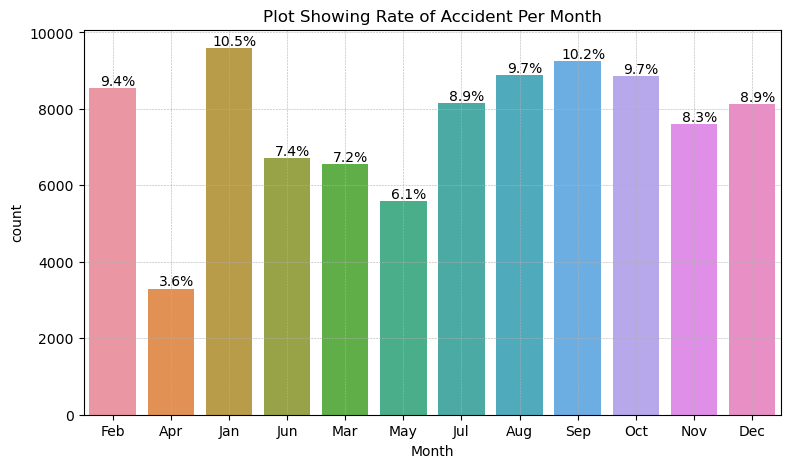

In [74]:
countplot_func(data=accident_copy,main_data=accident_copy,plot_size=(9,5),xlabel='Month',
               plot_title='Plot Showing Rate of Accident Per Month',plot_variable='Month',add_count=False)

- Most accidents happened in January while the least happened in April.

## Question 1
### Accident significant hours and days of the week.

In [75]:
accident_copy.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020010219808           2020          010219808                  3   
1  2020010220496           2020          010220496                  3   
2  2020010228005           2020          010228005                  3   
3  2020010228006           2020          010228006                  2   
4  2020010228011           2020          010228011                  3   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.254001  51.462262                    E09000032                   1   
1  -0.139253  51.470327                    E09000022                   1   
2  -0.178719  51.529614                    E09000033                   1   
3  -0.001683  51.541210                    E09000025                   1   
4  -0.137592  51.515704                    E09000033                   1   

   number_of_casualties       date  day_of_week   time  road_type  \
0                     1 2020-02-04            3  09:00          6   
1                     2 2020-04-27            2  13:55          6   
2                     1 2020-01-01            4  01:25          6   
3                     1 2020-01-01            4  01:50          6   
4                     2 2020-01-01            4  02:25          6   

   speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0           20                   9                    1                 1   
1           20                   1                    1                 1   
2           30                   1                    1                 4   
3           30                   1                    1                 4   
4           30                   1                    1                 4   

  lsoa_of_accident_location Month  
0                 E01004576   Feb  
1                 E01003034   Apr  
2                 E01004726   Jan  
3                 E01003617   Jan  
4                 E01004763   Jan

In [76]:
catalogue[catalogue['field name']=='day_of_week']

table   field name code/format      label note
65  Accident  day_of_week           1     Sunday  NaN
66  Accident  day_of_week           2     Monday  NaN
67  Accident  day_of_week           3    Tuesday  NaN
68  Accident  day_of_week           4  Wednesday  NaN
69  Accident  day_of_week           5   Thursday  NaN
70  Accident  day_of_week           6     Friday  NaN
71  Accident  day_of_week           7   Saturday  NaN

Converting weekday from number to real name:

In [77]:
week_day = catalogue[catalogue['field name']=='day_of_week']['label'].tolist()
code_format = catalogue[catalogue['field name']=='day_of_week']['code/format'].tolist()
week_dict = {}
for code, week in zip(code_format, week_day):
    if code == 5:
        week_dict[code] = week[:4]
    else:
        week_dict[code] = week[:3]
print(week_dict)

{1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thur', 6: 'Fri', 7: 'Sat'}


In [78]:
day_list = []
for week in accident_copy['day_of_week']:
    day_list.append(week_dict[week])
print(day_list[:5])

['Tue', 'Mon', 'Wed', 'Wed', 'Wed']


In [79]:
copy_data = accident_copy.copy()
copy_data['day_of_week'] = day_list

In [80]:
copy_data.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020010219808           2020          010219808                  3   
1  2020010220496           2020          010220496                  3   
2  2020010228005           2020          010228005                  3   
3  2020010228006           2020          010228006                  2   
4  2020010228011           2020          010228011                  3   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.254001  51.462262                    E09000032                   1   
1  -0.139253  51.470327                    E09000022                   1   
2  -0.178719  51.529614                    E09000033                   1   
3  -0.001683  51.541210                    E09000025                   1   
4  -0.137592  51.515704                    E09000033                   1   

   number_of_casualties       date day_of_week   time  road_type  speed_limit  \
0                     1 2020-02-04         Tue  09:00          6           20   
1                     2 2020-04-27         Mon  13:55          6           20   
2                     1 2020-01-01         Wed  01:25          6           30   
3                     1 2020-01-01         Wed  01:50          6           30   
4                     2 2020-01-01         Wed  02:25          6           30   

   weather_conditions  urban_or_rural_area  light_conditions  \
0                   9                    1                 1   
1                   1                    1                 1   
2                   1                    1                 4   
3                   1                    1                 4   
4                   1                    1                 4   

  lsoa_of_accident_location Month  
0                 E01004576   Feb  
1                 E01003034   Apr  
2                 E01004726   Jan  
3                 E01003617   Jan  
4                 E01004763   Jan

Adding Region Name From LSOA Table to data.

In [81]:
loc_table = lsoa_df.copy()
loc_table.rename(columns={'lsoa01cd':'lsoa_of_accident_location', 'lsoa01nm':'Region'}, inplace=True)
local = []
for loc in loc_table['Region']:
    local.append(loc[:-5])
loc_table['Region'] = local
loc_table = loc_table[['lsoa_of_accident_location','Region']]
loc_table.head()

lsoa_of_accident_location          Region
0                 E01000001  City of London
1                 E01000002  City of London
2                 E01000003  City of London
3                 E01000004  City of London
4                 E01000005  City of London

In [82]:
copy_data = pd.merge(copy_data, loc_table, on='lsoa_of_accident_location')

### 1a. Significant days of the week:

In [83]:
top = copy_data['day_of_week'].value_counts()
top = top.reset_index().rename(columns = {'index':'Days', 'day_of_week':'Frequency'})
top

Days  Frequency
0   Fri      13550
1  Thur      12859
2   Wed      12388
3   Tue      12104
4   Mon      11637
5   Sat      11177
6   Sun       9439

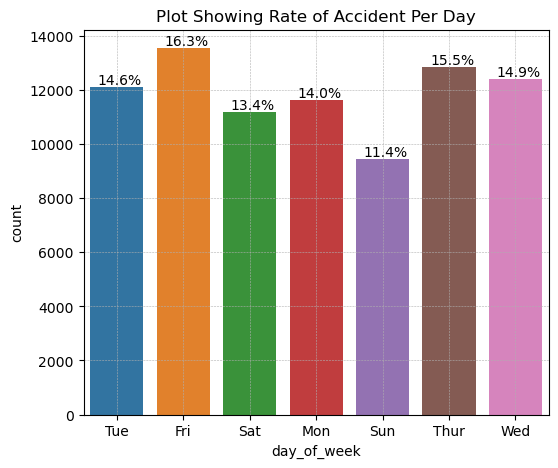

In [84]:
countplot_func(data=copy_data,main_data=copy_data,plot_size=(6,5),xlabel='day_of_week',
               plot_title='Plot Showing Rate of Accident Per Day',plot_variable='day_of_week',add_count=False)

- Accident occur the most on Fridays (16.3%) followed by Thursday (15.5%).

In [85]:
data_fri = copy_data[copy_data['day_of_week']=='Fri']

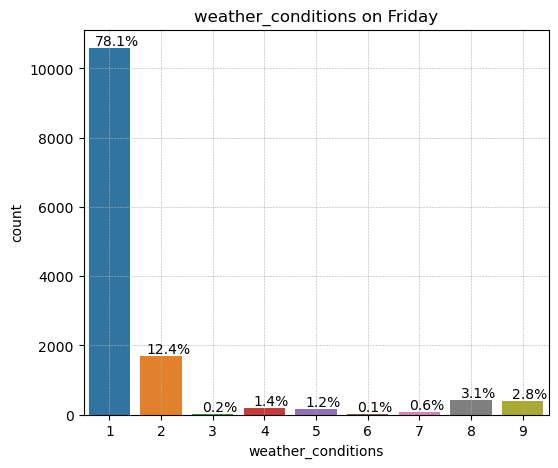

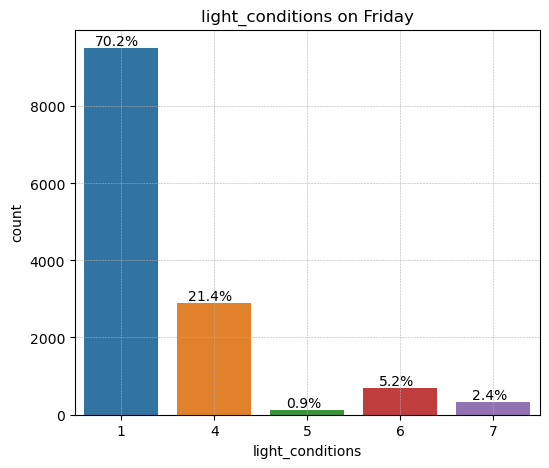

In [86]:
for col in data_fri[['weather_conditions','light_conditions']]:
    countplot_func(data=data_fri,main_data=data_fri,plot_size=(6,5),xlabel=col,
                   plot_title=f'{col} on Friday',plot_variable=col,add_count=False)

In [87]:
top_10_region = data_fri['Region'].value_counts()[:10]
top_10_region = top_10_region.reset_index().rename(columns = {'index':'Region', 'Region':'Frequency'})
top_10_region

Region  Frequency
0   Birmingham        250
1      Lambeth        173
2  Westminster        162
3   Wandsworth        157
4      Croydon        149
5        Leeds        138
6    Southwark        134
7       Ealing        133
8      Enfield        130
9      Hackney        124

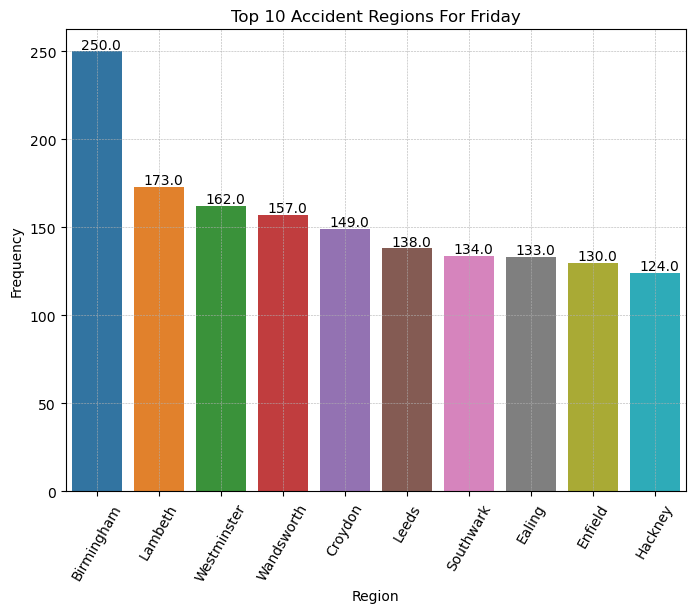

In [88]:
barplot_func(data=top_10_region,main_data=top_10_region,plot_size=(8,6),x='Region',y='Frequency',xlabel='Region',
             plot_title='Top 10 Accident Regions For Friday',plot_variable='Region',add_count=True,xticks=60)

- Birmingham had the highest accident rate on Friday.

#### 1b. Significant hours (time) of day

In [89]:
top_10_hours = copy_data['time'].value_counts()[:10]
top_10_hours = top_10_hours.reset_index().rename(columns = {'index':'Time', 'time':'Frequency'})
top_10_hours

Time  Frequency
0  17:00        763
1  15:00        711
2  16:00        706
3  17:30        665
4  18:00        661
5  15:30        634
6  14:00        622
7  16:30        622
8  18:30        560
9  13:00        539

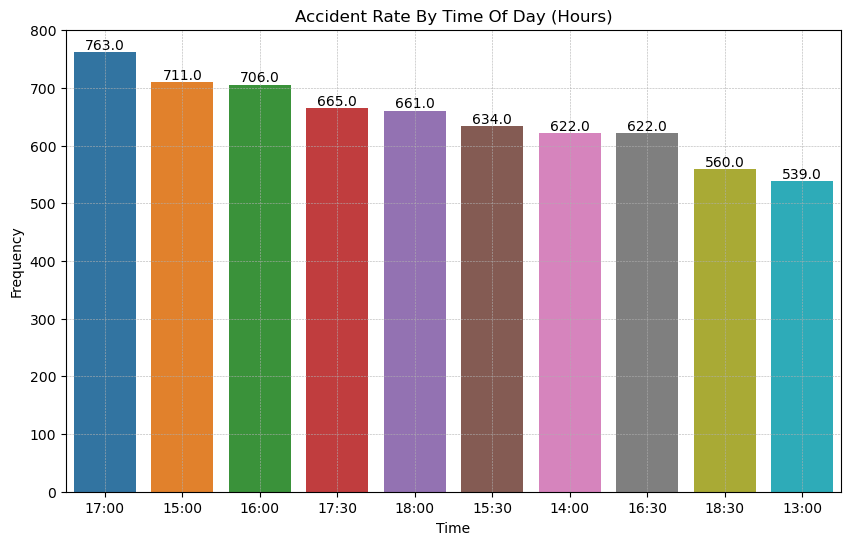

In [90]:
barplot_func(data=top_10_hours,main_data=top_10_hours,plot_size=(10,6),x='Time',y='Frequency',xlabel='Time',
             plot_title='Accident Rate By Time Of Day (Hours)',plot_variable='Time',add_count=True)

- Accident occur the most at 17:00 hours.

## Question 2

In [91]:
copy_data.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020010219808           2020          010219808                  3   
1  2020010240428           2020          010240428                  2   
2  2020010249713           2020          010249713                  3   
3  2020010255288           2020          010255288                  3   
4  2020010281740           2020          010281740                  3   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.254001  51.462262                    E09000032                   1   
1  -0.254734  51.455133                    E09000032                   2   
2  -0.251563  51.460148                    E09000032                   2   
3  -0.254795  51.458056                    E09000032                   2   
4  -0.256643  51.455278                    E09000032                   2   

   number_of_casualties       date day_of_week   time  road_type  speed_limit  \
0                     1 2020-02-04         Tue  09:00          6           20   
1                     1 2020-03-06         Fri  10:03          6           30   
2                     1 2020-05-30         Sat  11:55          6           60   
3                     1 2020-07-07         Tue  10:52          6           30   
4                     1 2020-11-28         Sat  14:00          6           20   

   weather_conditions  urban_or_rural_area  light_conditions  \
0                   9                    1                 1   
1                   1                    1                 1   
2                   1                    1                 1   
3                   1                    1                 1   
4                   1                    1                 1   

  lsoa_of_accident_location Month      Region  
0                 E01004576   Feb  Wandsworth  
1                 E01004576   Mar  Wandsworth  
2                 E01004576   May  Wandsworth  
3                 E01004576   Jul  Wandsworth  
4                 E01004576   Nov  Wandsworth

In [92]:
vehicle_df.head()

vehicle_index accident_index  accident_year accident_reference  \
0         681716  2020010219808           2020          010219808   
1         681717  2020010220496           2020          010220496   
2         681718  2020010228005           2020          010228005   
3         681719  2020010228006           2020          010228006   
4         681720  2020010228011           2020          010228011   

   vehicle_reference  vehicle_type  towing_and_articulation  \
0                  1             9                        9   
1                  1             9                        0   
2                  1             9                        0   
3                  1             8                        0   
4                  1             9                        0   

   vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  \
0                  5                       1                     5   
1                  4                       2                     6   
2                 18                      -1                    -1   
3                 18                       1                     5   
4                 18                       3                     7   

   vehicle_location_restricted_lane  junction_location  \
0                                 0                  0   
1                                 0                  2   
2                                 0                  0   
3                                 0                  0   
4                                 9                  1   

   skidding_and_overturning  hit_object_in_carriageway  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   vehicle_leaving_carriageway  hit_object_off_carriageway  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   first_point_of_impact  vehicle_left_hand_drive  journey_purpose_of_driver  \
0                      4                        9                          6   
1                      1                        1                          2   
2                      1                        1                          6   
3                      1                        1                          1   
4                      1                        1                          6   

   sex_of_driver  age_of_driver  age_band_of_driver  engine_capacity_cc  \
0              2             32                   6                1968   
1              1             45                   7                1395   
2              3             -1                  -1                  -1   
3              1             44                   7                1798   
4              1             20                   4                2993   

   propulsion_code  age_of_vehicle generic_make_model  driver_imd_decile  \
0                2               6            AUDI Q5                  4   
1                1               2            AUDI A1                  7   
2               -1              -1                 -1                 -1   
3                8               8       TOYOTA PRIUS                  2   
4                2               4       BMW 4 SERIES                 -1   

   driver_home_area_type  
0                      1  
1                      1  
2                     -1  
3                      1  
4                     -1

In [93]:
# Obtaining vehicle records for specified motorbikes:
veh_data = vehicle_df[vehicle_df['vehicle_type'].isin([2,3,4,5])][['accident_index', 'vehicle_type']]

In [94]:
veh_data.head()

accident_index  vehicle_type
12  2020010228020             3
32  2020010228077             2
33  2020010228086             3
36  2020010228097             3
58  2020010228148             3

In [95]:
# Merging veh_data to the accident data:
data = copy_data.merge(veh_data, on='accident_index')

In [96]:
data.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020010275471           2020          010275471                  3   
1  2020010247918           2020          010247918                  3   
2  2020010263313           2020          010263313                  2   
3  2020010232144           2020          010232144                  3   
4  2020010234226           2020          010234226                  3   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.143053  51.468579                    E09000022                   2   
1  -0.179660  51.529161                    E09000033                   2   
2  -0.172935  51.533265                    E09000033                   2   
3   0.001071  51.543168                    E09000025                   2   
4   0.000806  51.543047                    E09000025                   1   

   number_of_casualties       date day_of_week   time  road_type  speed_limit  \
0                     1 2020-10-22        Thur  16:40          2           20   
1                     1 2020-05-16         Sat  10:30          3           30   
2                     1 2020-08-21         Fri  20:21          3           30   
3                     1 2020-01-18         Sat  14:55          6           30   
4                     1 2020-01-28         Tue  11:53          6           30   

   weather_conditions  urban_or_rural_area  light_conditions  \
0                   2                    1                 1   
1                   1                    1                 1   
2                   4                    1                 1   
3                   9                    1                 1   
4                   1                    1                 1   

  lsoa_of_accident_location Month       Region  vehicle_type  
0                 E01003034   Oct      Lambeth             3  
1                 E01004726   May  Westminster             3  
2                 E01004726   Aug  Westminster             3  
3                 E01003617   Jan       Newham             3  
4                 E01003617   Jan       Newham             4

In [97]:
data.isna().sum()

accident_index                  0
accident_year                   0
accident_reference              0
accident_severity               0
longitude                       0
latitude                        0
local_authority_ons_district    0
number_of_vehicles              0
number_of_casualties            0
date                            0
day_of_week                     0
time                            0
road_type                       0
speed_limit                     0
weather_conditions              0
urban_or_rural_area             0
light_conditions                0
lsoa_of_accident_location       0
Month                           0
Region                          0
vehicle_type                    0
dtype: int64

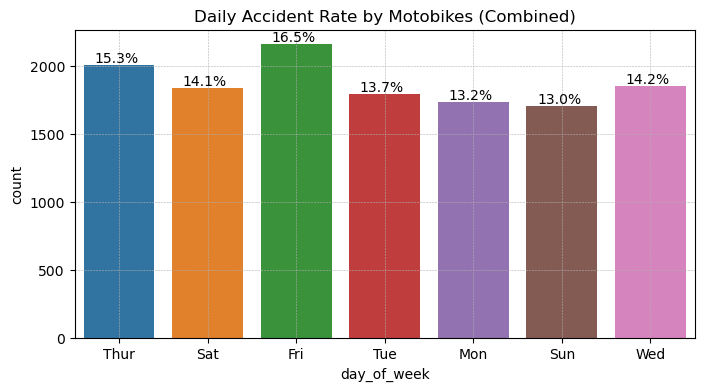

In [98]:
countplot_func(data=data,main_data=data,plot_size=(8,4),xlabel='day_of_week',
               plot_title='Daily Accident Rate by Motobikes (Combined)',plot_variable='day_of_week',add_count=False)

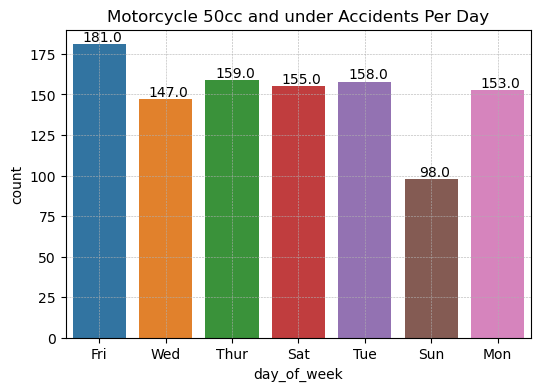

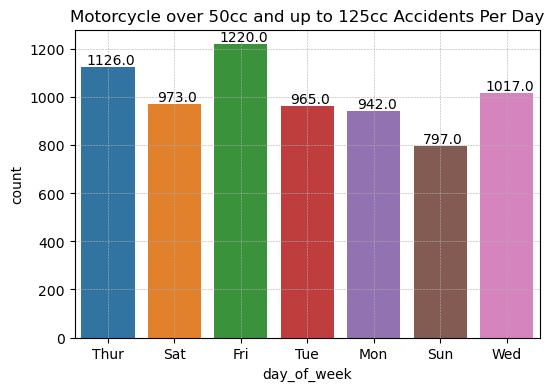

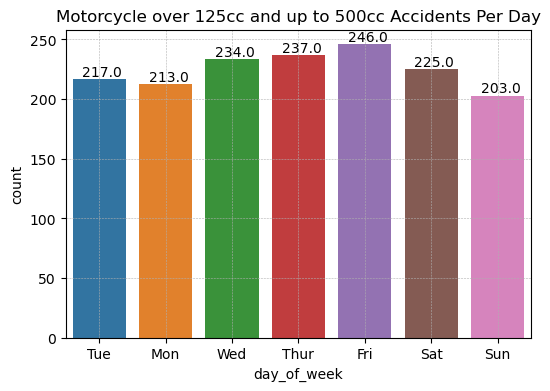

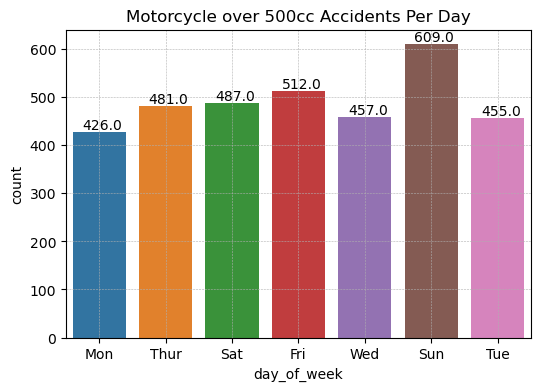

In [99]:
motorbikes = ['Motorcycle 50cc and under','Motorcycle over 50cc and up to 125cc',\
              'Motorcycle over 125cc and up to 500cc','Motorcycle over 500cc']
for bikes, num in zip(motorbikes, range(2,6)):
    countplot_func(data=data[data['vehicle_type']==num],main_data=data,plot_size=(6,4),xlabel='day_of_week',
                             plot_title=f'{bikes} Accidents Per Day',plot_variable='day_of_week',add_count=True)

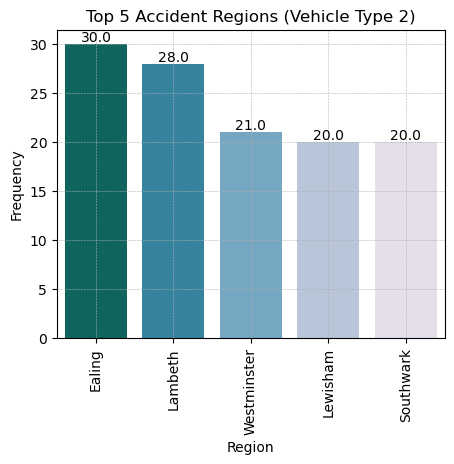

Region  Frequency
0       Ealing         30
1      Lambeth         28
2  Westminster         21
3     Lewisham         20
4    Southwark         20

In [100]:
bike_1_data = data[data['vehicle_type']==2]
top_10_region1 = bike_1_data['Region'].value_counts()[:5]
top_10_region1 = top_10_region1.reset_index().rename(columns = {'index':'Region', 'Region':'Frequency'})
barplot_func2(data=top_10_region1,main_data=top_10_region1,plot_size=(5,4),x='Region',y='Frequency',xlabel='Region',
             plot_title='Top 5 Accident Regions (Vehicle Type 2)',plot_variable='Region',add_count=True,xticks=90)
top_10_region1

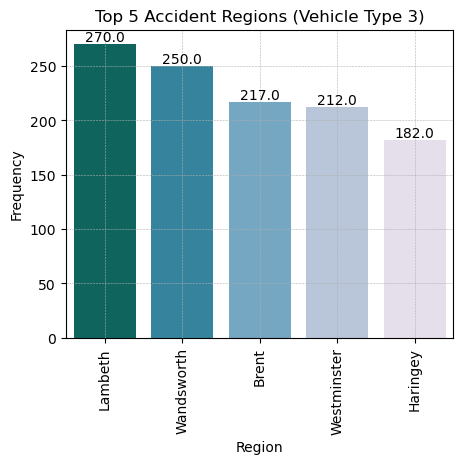

Region  Frequency
0      Lambeth        270
1   Wandsworth        250
2        Brent        217
3  Westminster        212
4     Haringey        182

In [101]:
bike_1_data = data[data['vehicle_type']==3]
top_10_region1 = bike_1_data['Region'].value_counts()[:5]
top_10_region1 = top_10_region1.reset_index().rename(columns = {'index':'Region', 'Region':'Frequency'})
barplot_func2(data=top_10_region1,main_data=top_10_region1,plot_size=(5,4),x='Region',y='Frequency',xlabel='Region',
             plot_title='Top 5 Accident Regions (Vehicle Type 3)',plot_variable='Region',add_count=True,xticks=90)
top_10_region1

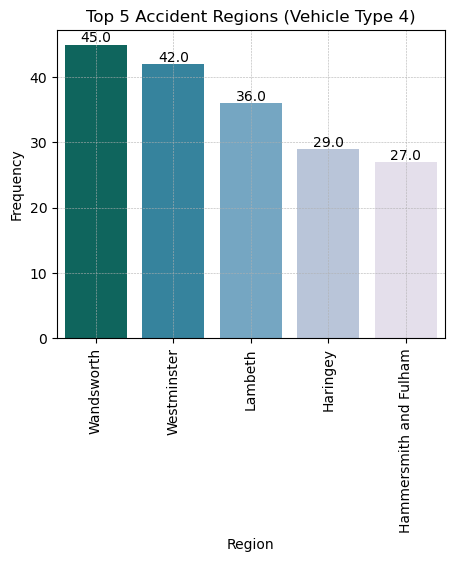

Region  Frequency
0              Wandsworth         45
1             Westminster         42
2                 Lambeth         36
3                Haringey         29
4  Hammersmith and Fulham         27

In [102]:
bike_1_data = data[data['vehicle_type']==4]
top_10_region2 = bike_1_data['Region'].value_counts()[:5]
top_10_region2 = top_10_region2.reset_index().rename(columns = {'index':'Region', 'Region':'Frequency'})
barplot_func2(data=top_10_region2,main_data=top_10_region2,plot_size=(5,4),x='Region',y='Frequency',xlabel='Region',
             plot_title='Top 5 Accident Regions (Vehicle Type 4)',plot_variable='Region',add_count=True,xticks=90)
top_10_region2

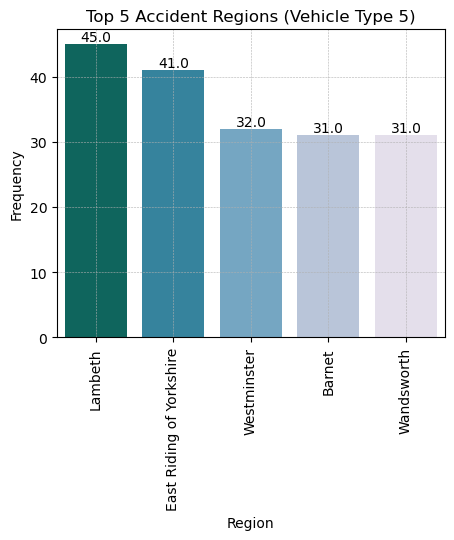

Region  Frequency
0                   Lambeth         45
1  East Riding of Yorkshire         41
2               Westminster         32
3                    Barnet         31
4                Wandsworth         31

In [103]:
bike_1_data = data[data['vehicle_type']==5]
top_10_region3 = bike_1_data['Region'].value_counts()[:5]
top_10_region3 = top_10_region3.reset_index().rename(columns = {'index':'Region', 'Region':'Frequency'})
barplot_func2(data=top_10_region3,main_data=top_10_region3,plot_size=(5,4),x='Region',y='Frequency',xlabel='Region',
             plot_title='Top 5 Accident Regions (Vehicle Type 5)',plot_variable='Region',add_count=True,xticks=90)
top_10_region3

#### Significant hours for each motorbikes:

In [104]:
# Obtaining top 10 accident occurence based on time for each motorbikes:
top_10_hours_bike_2 = data[data['vehicle_type']==2]['time'].value_counts()[:10]
top_10_hours_bike_2 = top_10_hours_bike_2.reset_index().rename(columns = {'index':'Time', 'time':'Frequency'})

top_10_hours_bike_3 = data[data['vehicle_type']==3]['time'].value_counts()[:10]
top_10_hours_bike_3 = top_10_hours_bike_3.reset_index().rename(columns = {'index':'Time', 'time':'Frequency'})

top_10_hours_bike_4 = data[data['vehicle_type']==4]['time'].value_counts()[:10]
top_10_hours_bike_4 = top_10_hours_bike_4.reset_index().rename(columns = {'index':'Time', 'time':'Frequency'})

top_10_hours_bike_5 = data[data['vehicle_type']==5]['time'].value_counts()[:10]
top_10_hours_bike_5 = top_10_hours_bike_5.reset_index().rename(columns = {'index':'Time', 'time':'Frequency'})

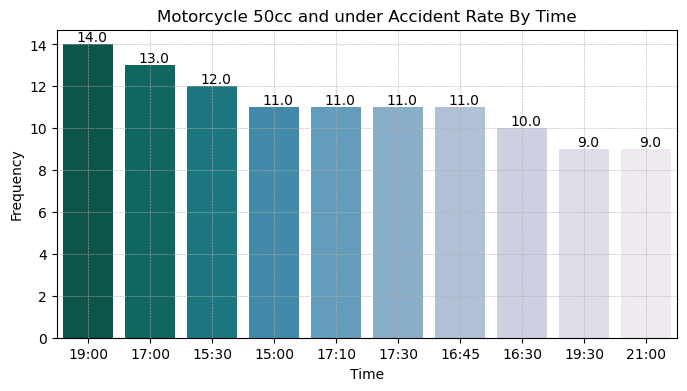

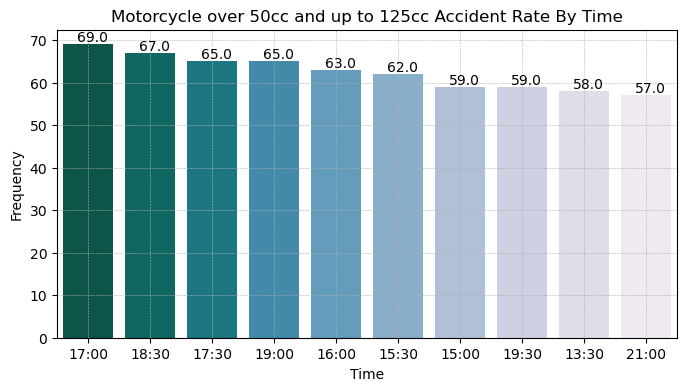

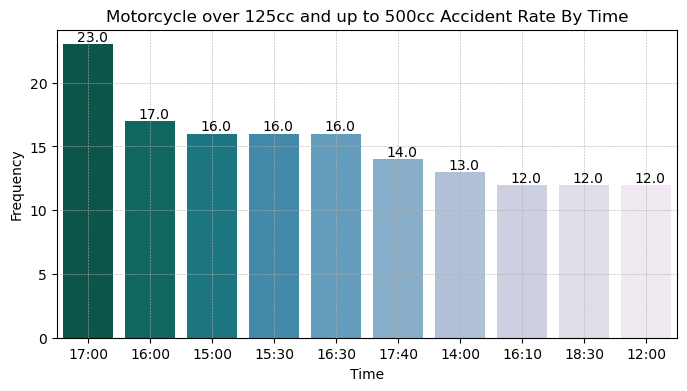

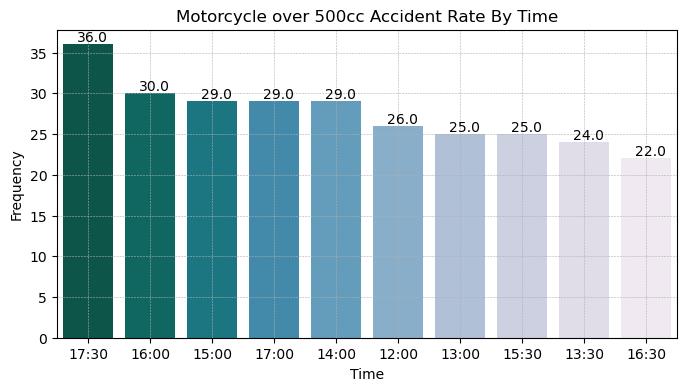

In [105]:
# Visualizing time frequencies for specified motorbikes:
motorbikes =  ['Motorcycle 50cc and under','Motorcycle over 50cc and up to 125cc',\
               'Motorcycle over 125cc and up to 500cc','Motorcycle over 500cc']
df_list = [top_10_hours_bike_2,top_10_hours_bike_3, top_10_hours_bike_4, top_10_hours_bike_5]
for bikes, df in zip(motorbikes, df_list):
    barplot_func2(data=df,main_data=df,plot_size=(8,4),x='Time',y='Frequency',xlabel='Time',
             plot_title=f'{bikes} Accident Rate By Time',plot_variable='Time',add_count=True)

## Question 3

According to stat-19 document, casaulty class for pedestrian is 3.

In [106]:
pedestrian_df = casualty_df[casualty_df['casualty_class']==3]

In [107]:
pedestrian_df[['accident_index','casualty_class']]

accident_index  casualty_class
0       2020010219808               3
1       2020010220496               3
2       2020010220496               3
3       2020010228005               3
4       2020010228006               3
...               ...             ...
115573  2020991023621               3
115574  2020991023880               3
115578  2020991024526               3
115580  2020991029573               3
115583  2020991032575               3

[14750 rows x 2 columns]

In [108]:
#Merging the accident data with the casualty table for pedestrians:
new_data = copy_data.merge(pedestrian_df[['accident_index','casualty_class']], on='accident_index')

In [109]:
new_data

accident_index  accident_year accident_reference  accident_severity  \
0      2020010219808           2020          010219808                  3   
1      2020010220496           2020          010220496                  3   
2      2020010220496           2020          010220496                  3   
3      2020010228005           2020          010228005                  3   
4      2020010237355           2020          010237355                  3   
...              ...            ...                ...                ...   
13074  202063D082120           2020          63D082120                  2   
13075  202063DF01120           2020          63DF01120                  1   
13076  202063D085720           2020          63D085720                  3   
13077  202063D065920           2020          63D065920                  3   
13078  202063D077120           2020          63D077120                  2   

       longitude   latitude local_authority_ons_district  number_of_vehicles  \
0      -0.254001  51.462262                    E09000032                   1   
1      -0.139253  51.470327                    E09000022                   1   
2      -0.139253  51.470327                    E09000022                   1   
3      -0.178719  51.529614                    E09000033                   1   
4      -0.172031  51.533539                    E09000033                   2   
...          ...        ...                          ...                 ...   
13074  -3.510591  52.300371                    W06000023                   1   
13075  -3.107776  52.770987                    W06000023                   1   
13076  -3.332816  52.504356                    W06000023                   1   
13077  -3.379222  52.240120                    W06000023                   1   
13078  -3.391374  51.949108                    W06000023                   1   

       number_of_casualties       date day_of_week   time  road_type  \
0                         1 2020-02-04         Tue  09:00          6   
1                         2 2020-04-27         Mon  13:55          6   
2                         2 2020-04-27         Mon  13:55          6   
3                         1 2020-01-01         Wed  01:25          6   
4                         1 2020-02-12         Wed  14:00          6   
...                     ...        ...         ...    ...        ...   
13074                     1 2020-12-03        Thur  16:50          6   
13075                     2 2020-11-06         Fri  15:28          6   
13076                     1 2020-12-16         Wed  08:30          6   
13077                     1 2020-09-23         Wed  18:30          2   
13078                     1 2020-11-06         Fri  10:15          6   

       speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0               20                   9                    1                 1   
1               20                   1                    1                 1   
2               20                   1                    1                 1   
3               30                   1                    1                 4   
4               30                   1                    1                 1   
...            ...                 ...                  ...               ...   
13074           30                   3                    2                 4   
13075           60                   1                    2                 1   
13076           20                   2                    1                 1   
13077           30                   1                    2                 1   
13078           30                   1                    2                 1   

      lsoa_of_accident_location Month       Region  casualty_class  
0                     E01004576   Feb   Wandsworth               3  
1                     E01003034   Apr      Lambeth               3  
2                     E01003034   Apr      Lambeth               3  
3     

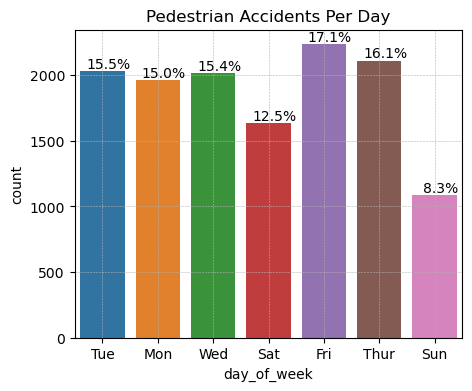

In [110]:
countplot_func(data=new_data,main_data=new_data,plot_size=(5,4),xlabel='day_of_week',
               plot_title='Pedestrian Accidents Per Day',plot_variable='day_of_week',add_count=False)

In [111]:
def top_n_regions(data, feature, day):
    top_5_region = data[feature].value_counts()[:5]
    top_5_region = top_5_region.reset_index().rename(columns = {'index':feature, feature:'Frequency'})
    plot = barplot_func2(data=top_5_region,main_data=top_5_region,plot_size=(5,4),x=feature,y='Frequency',xlabel='Region',
                 plot_title=f'Top 5 Accident Regions on {day}',plot_variable=feature,add_count=True,xticks=90)
    return top_5_region, plot

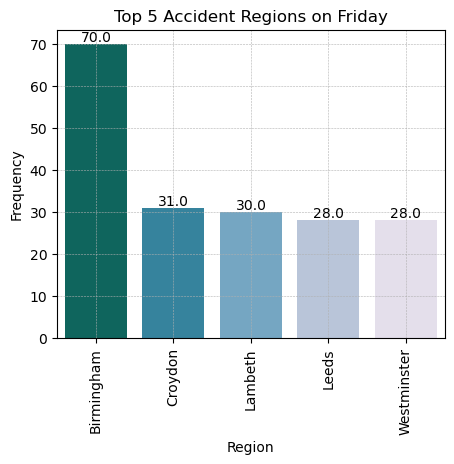

(        Region  Frequency
 0   Birmingham         70
 1      Croydon         31
 2      Lambeth         30
 3        Leeds         28
 4  Westminster         28,
 None)

In [112]:
top_n_regions(data=new_data[new_data['day_of_week']=='Fri'], feature='Region', day='Friday')

In [113]:
top_10_hours_ped = new_data['time'].value_counts()[:10]
top_10_hours_ped = top_10_hours_ped.reset_index().rename(columns = {'index':'Time', 'time':'Frequency'})
top_10_hours_ped

Time  Frequency
0  15:30        167
1  15:00        149
2  16:00        134
3  18:00        130
4  16:30        129
5  17:00        123
6  19:00        115
7  14:00        113
8  17:30        113
9  18:30        107

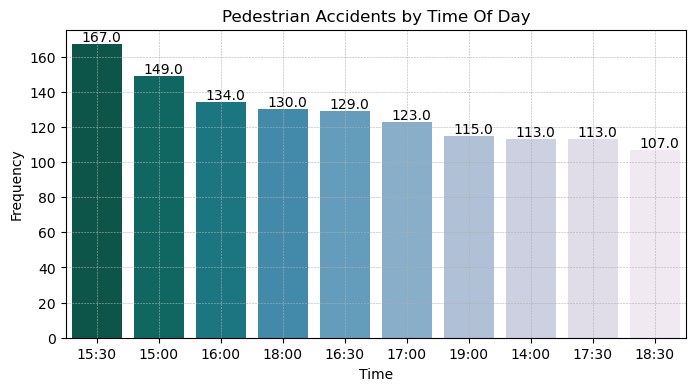

In [114]:
barplot_func2(data=top_10_hours_ped,main_data=top_10_hours_ped,plot_size=(8,4),x='Time',y='Frequency',xlabel='Time',
             plot_title='Pedestrian Accidents by Time Of Day',plot_variable='Time',add_count=True)

## Question 4

In [115]:
accident_copy.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020010219808           2020          010219808                  3   
1  2020010220496           2020          010220496                  3   
2  2020010228005           2020          010228005                  3   
3  2020010228006           2020          010228006                  2   
4  2020010228011           2020          010228011                  3   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.254001  51.462262                    E09000032                   1   
1  -0.139253  51.470327                    E09000022                   1   
2  -0.178719  51.529614                    E09000033                   1   
3  -0.001683  51.541210                    E09000025                   1   
4  -0.137592  51.515704                    E09000033                   1   

   number_of_casualties       date  day_of_week   time  road_type  \
0                     1 2020-02-04            3  09:00          6   
1                     2 2020-04-27            2  13:55          6   
2                     1 2020-01-01            4  01:25          6   
3                     1 2020-01-01            4  01:50          6   
4                     2 2020-01-01            4  02:25          6   

   speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0           20                   9                    1                 1   
1           20                   1                    1                 1   
2           30                   1                    1                 4   
3           30                   1                    1                 4   
4           30                   1                    1                 4   

  lsoa_of_accident_location Month  
0                 E01004576   Feb  
1                 E01003034   Apr  
2                 E01004726   Jan  
3                 E01003617   Jan  
4                 E01004763   Jan

Selecting variable with impact on road safety:

In [116]:
features = ['speed_limit','weather_conditions','light_conditions','number_of_vehicles','road_type','accident_severity']
accident_data = accident_copy[features]

In [117]:
accident_data.head()

speed_limit  weather_conditions  light_conditions  number_of_vehicles  \
0           20                   9                 1                   1   
1           20                   1                 1                   1   
2           30                   1                 4                   1   
3           30                   1                 4                   1   
4           30                   1                 4                   1   

   road_type  accident_severity  
0          6                  3  
1          6                  3  
2          6                  3  
3          6                  2  
4          6                  3

In [118]:
# Renaming features for simplicity:
accident_data.rename(columns={'speed_limit':'speed','number_of_vehicles':'num_vehicle','light_conditions':'light',\
                              'weather_conditions':'weather', 'accident_severity':'severity'},
                    inplace=True)
accident_data.head()

speed  weather  light  num_vehicle  road_type  severity
0     20        9      1            1          6         3
1     20        1      1            1          6         3
2     30        1      4            1          6         3
3     30        1      4            1          6         2
4     30        1      4            1          6         3

In [119]:
# Encoding the features:
encode_data = pd.get_dummies(accident_data, columns=accident_data.columns)
encode_data.head()

speed_20  speed_30  speed_40  speed_50  speed_60  speed_70  weather_1  \
0         1         0         0         0         0         0          0   
1         1         0         0         0         0         0          1   
2         0         1         0         0         0         0          1   
3         0         1         0         0         0         0          1   
4         0         1         0         0         0         0          1   

   weather_2  weather_3  weather_4  weather_5  weather_6  weather_7  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   weather_8  weather_9  light_1  light_4  light_5  light_6  light_7  \
0          0          1        1        0        0        0        0   
1          0          0        1        0        0        0        0   
2          0          0        0        1        0        0        0   
3          0          0        0        1        0        0        0   
4          0          0        0        1        0        0        0   

   num_vehicle_1  num_vehicle_2  num_vehicle_3  num_vehicle_4  num_vehicle_5  \
0              1              0              0              0              0   
1              1              0              0              0              0   
2              1              0              0              0              0   
3              1              0              0              0              0   
4              1              0              0              0              0   

   num_vehicle_6  num_vehicle_7  num_vehicle_8  num_vehicle_9  num_vehicle_10  \
0              0              0              0              0               0   
1              0              0              0              0               0   
2              0              0              0              0               0   
3              0              0              0              0               0   
4              0              0              0              0               0   

   num_vehicle_11  num_vehicle_12  num_vehicle_13  road_type_1  road_type_2  \
0               0               0               0            0            0   
1               0               0               0            0            0   
2               0               0               0            0            0   
3               0               0               0            0            0   
4               0               0               0            0            0   

   road_type_3  road_type_6  road_type_7  road_type_9  severity_1  severity_2  \
0            0            1            0            0           0           0   
1            0            1            0            0           0           0   
2            0            1            0            0           0           0   
3            0            1            0            0           0           1   
4            0            1            0            0           0           0   

   severity_3  
0           1  
1           1  
2           1  
3           0  
4           1

In [120]:
# Generating support:
support_df = apriori(encode_data, min_support=0.2, use_colnames=True)
support_df

C:\Users\ohiom\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


support                                           itemsets
0   0.573087                                         (speed_30)
1   0.775557                                        (weather_1)
2   0.706784                                          (light_1)
3   0.208621                                          (light_4)
4   0.282130                                    (num_vehicle_1)
..       ...                                                ...
58  0.336221      (road_type_6, light_1, weather_1, severity_3)
59  0.288150  (road_type_6, weather_1, num_vehicle_2, severi...
60  0.271746  (road_type_6, light_1, num_vehicle_2, severity_3)
61  0.219937  (speed_30, severity_3, weather_1, road_type_6,...
62  0.225496  (num_vehicle_2, severity_3, weather_1, road_ty...

[63 rows x 2 columns]

In [121]:
# Generating the rules:
rules_assoc = association_rules(support_df,metric='confidence',min_threshold=0.83)
rules_assoc

antecedents   consequents  \
0                     (speed_30, num_vehicle_2)  (severity_3)   
1            (light_1, speed_30, num_vehicle_2)   (weather_1)   
2              (road_type_6, light_1, speed_30)   (weather_1)   
3          (speed_30, weather_1, num_vehicle_2)  (severity_3)   
4            (light_1, speed_30, num_vehicle_2)  (severity_3)   
5         (road_type_6, light_1, num_vehicle_2)   (weather_1)   
6  (road_type_6, light_1, speed_30, severity_3)   (weather_1)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.370662            0.783484  0.311253    0.839723  1.071780   
1            0.270365            0.775557  0.225562    0.834286  1.075726   
2            0.329247            0.775557  0.275354    0.836314  1.078340   
3            0.294280            0.783484  0.245222    0.833296  1.063577   
4            0.270365            0.783484  0.227853    0.842763  1.075660   
5            0.336583            0.775557  0.281801    0.837243  1.079538   
6            0.264564            0.775557  0.219937    0.831316  1.071896   

   leverage  conviction  zhangs_metric  
0  0.020846    1.350884       0.106418  
1  0.015878    1.354405       0.096480  
2  0.020004    1.371182       0.108309  
3  0.014659    1.298803       0.084703  
4  0.016027    1.376999       0.096402  
5  0.020762    1.379005       0.111057  
6  0.014752    1.330557       0.091203

In [122]:
rules_assoc['length'] = [len(consequents) for consequents in rules_assoc['consequents']]

In [123]:
rules_assoc

antecedents   consequents  \
0                     (speed_30, num_vehicle_2)  (severity_3)   
1            (light_1, speed_30, num_vehicle_2)   (weather_1)   
2              (road_type_6, light_1, speed_30)   (weather_1)   
3          (speed_30, weather_1, num_vehicle_2)  (severity_3)   
4            (light_1, speed_30, num_vehicle_2)  (severity_3)   
5         (road_type_6, light_1, num_vehicle_2)   (weather_1)   
6  (road_type_6, light_1, speed_30, severity_3)   (weather_1)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.370662            0.783484  0.311253    0.839723  1.071780   
1            0.270365            0.775557  0.225562    0.834286  1.075726   
2            0.329247            0.775557  0.275354    0.836314  1.078340   
3            0.294280            0.783484  0.245222    0.833296  1.063577   
4            0.270365            0.783484  0.227853    0.842763  1.075660   
5            0.336583            0.775557  0.281801    0.837243  1.079538   
6            0.264564            0.775557  0.219937    0.831316  1.071896   

   leverage  conviction  zhangs_metric  length  
0  0.020846    1.350884       0.106418       1  
1  0.015878    1.354405       0.096480       1  
2  0.020004    1.371182       0.108309       1  
3  0.014659    1.298803       0.084703       1  
4  0.016027    1.376999       0.096402       1  
5  0.020762    1.379005       0.111057       1  
6  0.014752    1.330557       0.091203       1

In [124]:
rules_assoc[rules_assoc['length']<2]

antecedents   consequents  \
0                     (speed_30, num_vehicle_2)  (severity_3)   
1            (light_1, speed_30, num_vehicle_2)   (weather_1)   
2              (road_type_6, light_1, speed_30)   (weather_1)   
3          (speed_30, weather_1, num_vehicle_2)  (severity_3)   
4            (light_1, speed_30, num_vehicle_2)  (severity_3)   
5         (road_type_6, light_1, num_vehicle_2)   (weather_1)   
6  (road_type_6, light_1, speed_30, severity_3)   (weather_1)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.370662            0.783484  0.311253    0.839723  1.071780   
1            0.270365            0.775557  0.225562    0.834286  1.075726   
2            0.329247            0.775557  0.275354    0.836314  1.078340   
3            0.294280            0.783484  0.245222    0.833296  1.063577   
4            0.270365            0.783484  0.227853    0.842763  1.075660   
5            0.336583            0.775557  0.281801    0.837243  1.079538   
6            0.264564            0.775557  0.219937    0.831316  1.071896   

   leverage  conviction  zhangs_metric  length  
0  0.020846    1.350884       0.106418       1  
1  0.015878    1.354405       0.096480       1  
2  0.020004    1.371182       0.108309       1  
3  0.014659    1.298803       0.084703       1  
4  0.016027    1.376999       0.096402       1  
5  0.020762    1.379005       0.111057       1  
6  0.014752    1.330557       0.091203       1

In [125]:
# Generating data for each severity type:
data1 = rules_assoc[rules_assoc['consequents']=={'severity_1'}]
data2 = rules_assoc[rules_assoc['consequents']=={'severity_2'}]
data3 = rules_assoc[rules_assoc['consequents']=={'severity_3'}]

In [126]:
data1

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric, length]
Index: []

In [127]:
data2

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric, length]
Index: []

- Empty dataframe indicates no associations with only severity 1 and 2 as consequence. 

In [128]:
print('Association Rules Table')
print('=' * 120)
data3.sort_values(by='confidence', ascending=False, inplace=True)
data3.drop('length', axis=1, inplace=True)
data3

Association Rules Table


antecedents   consequents  antecedent support  \
4    (light_1, speed_30, num_vehicle_2)  (severity_3)            0.270365   
0             (speed_30, num_vehicle_2)  (severity_3)            0.370662   
3  (speed_30, weather_1, num_vehicle_2)  (severity_3)            0.294280   

   consequent support   support  confidence      lift  leverage  conviction  \
4            0.783484  0.227853    0.842763  1.075660  0.016027    1.376999   
0            0.783484  0.311253    0.839723  1.071780  0.020846    1.350884   
3            0.783484  0.245222    0.833296  1.063577  0.014659    1.298803   

   zhangs_metric  
4       0.096402  
0       0.106418  
3       0.084703

## Question 5

In [129]:
lsoa_df

objectid   lsoa01cd             lsoa01nm            lsoa01nmw  \
0             1  E01000001  City of London 001A  City of London 001A   
1             2  E01000002  City of London 001B  City of London 001B   
2             3  E01000003  City of London 001C  City of London 001C   
3             4  E01000004  City of London 001D  City of London 001D   
4             5  E01000005  City of London 001E  City of London 001E   
...         ...        ...                  ...                  ...   
34373     34374  W01001892         Cardiff 020D        Caerdydd 020D   
34374     34375  W01001893         Cardiff 010B        Caerdydd 010B   
34375     34376  W01001894         Cardiff 010C        Caerdydd 010C   
34376     34377  W01001895         Cardiff 010D        Caerdydd 010D   
34377     34378  W01001896         Cardiff 020E        Caerdydd 020E   

        shape__area  shape__length                              globalid  
0      1.298652e+05    2635.772001  68cc6127-1008-4fbe-a16c-78fb089a7c43  
1      2.284189e+05    2707.986202  937edbc3-c1bf-4d35-b274-b0a1480a7c09  
2      5.905477e+04    1224.774479  2686dcaf-10b9-4736-92af-4788d4feaa69  
3      2.544551e+06   10718.466240  3c493140-0b3f-4b9a-b358-22011dc5fb89  
4      1.895782e+05    2275.809358  b569093d-788d-41be-816c-d6d7658b2311  
...             ...            ...                                   ...  
34373  2.699088e+05    2537.220060  1a25aa1e-5db5-4d32-8355-473409dbd69f  
34374  4.288488e+06    9807.284401  b6af5e24-eb2a-404a-98a6-a282037b3e10  
34375  3.337511e+05    2929.546177  72d16f53-115d-4926-936d-2f1b1d659d46  
34376  1.360174e+06    8141.281226  8e105eb9-f68e-4cdb-bca6-b49f6592cb71  
34377  3.124395e+05    3823.366435  c885f171-a56e-4e2b-8d09-1c7d6efedd67  

[34378 rows x 7 columns]

In [130]:
lsoa_loc_df = lsoa_df[lsoa_df['lsoa01nm'].str.contains('Kingston upon Hull|North Lincolnshire|North East Lincolnshire|East Riding of Yorkshire')]

In [131]:
lsoa_loc_df

objectid   lsoa01cd                 lsoa01nm                lsoa01nmw  \
12755     12756  E01012756  Kingston upon Hull 025A  Kingston upon Hull 025A   
12756     12757  E01012757  Kingston upon Hull 025B  Kingston upon Hull 025B   
12757     12758  E01012758  Kingston upon Hull 018A  Kingston upon Hull 018A   
12758     12759  E01012759  Kingston upon Hull 025C  Kingston upon Hull 025C   
12759     12760  E01012760  Kingston upon Hull 025D  Kingston upon Hull 025D   
...         ...        ...                      ...                      ...   
13329     13330  E01013330  North Lincolnshire 008D  North Lincolnshire 008D   
13330     13331  E01013331  North Lincolnshire 007D  North Lincolnshire 007D   
13331     13332  E01013332  North Lincolnshire 008E  North Lincolnshire 008E   
13332     13333  E01013333  North Lincolnshire 009C  North Lincolnshire 009C   
13333     13334  E01013334  North Lincolnshire 009D  North Lincolnshire 009D   

        shape__area  shape__length                              globalid  
12755  1.989409e+05    3498.355895  6f44ac4a-9449-4c64-8564-6f612bf9a060  
12756  3.180874e+05    3716.587517  e1c0a075-7ca8-425e-8437-39db56a6b994  
12757  3.119203e+05    3775.303823  a049347f-f7fb-481f-90ca-a95e632ac97a  
12758  3.981882e+05    3984.807880  f55da506-35c7-4db5-a007-bba4255d50e3  
12759  1.259992e+05    2082.915305  dc1e40d1-79fe-4cda-b204-d22f9362b043  
...             ...            ...                                   ...  
13329  4.929152e+05    5181.461487  b88c962b-f5fd-4040-b5e4-aec021f412c6  
13330  3.355854e+06    9792.250193  9d9e6f25-b4d0-4363-9a6b-db8733536325  
13331  2.863619e+05    3010.598961  6b70aa16-26d2-455e-b8c0-02a40e619bdf  
13332  3.722756e+05    3198.676882  dad7b11b-465f-4d51-9e29-5a5d7a17e3e8  
13333  6.801693e+05    3814.860089  9bb486fa-ba69-4bbb-9ff4-2b7eda70acce  

[579 rows x 7 columns]

In [132]:
accident_df

accident_index  accident_year accident_reference  location_easting_osgr  \
0      2020010219808           2020          010219808               521389.0   
1      2020010220496           2020          010220496               529337.0   
2      2020010228005           2020          010228005               526432.0   
3      2020010228006           2020          010228006               538676.0   
4      2020010228011           2020          010228011               529324.0   
...              ...            ...                ...                    ...   
91194  2020991027064           2020          991027064               343034.0   
91195  2020991029573           2020          991029573               257963.0   
91196  2020991030297           2020          991030297               383664.0   
91197  2020991030900           2020          991030900               277161.0   
91198  2020991032575           2020          991032575               240402.0   

       location_northing_osgr  longitude   latitude  police_force  \
0                    175144.0  -0.254001  51.462262             1   
1                    176237.0  -0.139253  51.470327             1   
2                    182761.0  -0.178719  51.529614             1   
3                    184371.0  -0.001683  51.541210             1   
4                    181286.0  -0.137592  51.515704             1   
...                       ...        ...        ...           ...   
91194                731654.0  -2.926320  56.473539            99   
91195                658891.0  -4.267565  55.802353            99   
91196                810646.0  -2.271903  57.186317            99   
91197                674852.0  -3.968753  55.950940            99   
91198                681950.0  -4.561040  56.003843            99   

       accident_severity  number_of_vehicles  number_of_casualties  \
0                      3                   1                     1   
1                      3                   1                     2   
2                      3                   1                     1   
3                      2                   1                     1   
4                      3                   1                     2   
...                  ...                 ...                   ...   
91194                  2                   2                     1   
91195                  3                   1                     1   
91196                  2                   2                     1   
91197                  3                   2                     1   
91198                  3                   1                     1   

             date  day_of_week   time  local_authority_district  \
0      04/02/2020            3  09:00                        10   
1      27/04/2020            2  13:55                         9   
2      01/01/2020            4  01:25                         1   
3      01/01/2020            4  01:50                        17   
4      01/01/2020            4  02:25                         1   
...           ...          ...    ...                       ...   
91194  12/08/2020            4  14:30                       918   
91195  13/11/2020            6  15:05                       922   
91196  15/04/2020            4  12:42                       910   
91197  15/12/2020            3  14:00                       932   
91198  25/08/2020            3  13:50                       916   

      local_authority_ons_district local_authority_highway  first_road_class  \
0                        E09000032               E09000032                 6   
1                        E09000022               E09000022                 3   
2                        E09000033               E09000033                 5   
3                        E09000025               E09000025                 3   
4                        E09000033               E09000033                 3   
...                            ...                     ...               ...  

In [133]:
# Obtaining the region name from the lsoa table:
name_list  = []
for location in lsoa_loc_df['lsoa01nm'].tolist():
    if str(location).startswith('Kingston upon Hull'):
        name_list.append('Kingston upon Hull')
    elif str(location).startswith('North Lincolnshire'):
        name_list.append('North Lincolnshire')
    elif str(location).startswith('North East Lincolnshire'):
        name_list.append('North East Lincolnshire')
    elif str(location).startswith('East Riding of Yorkshire'):
        name_list.append('East Riding of Yorkshire')
    else:
        continue

In [134]:
lsoa_loc_df['Region'] = name_list

In [135]:
lsoa_loc_df.sample(5)

objectid   lsoa01cd                       lsoa01nm  \
12865     12866  E01012866        Kingston upon Hull 018D   
12919     12920  E01012920  East Riding of Yorkshire 024A   
12899     12900  E01012900        Kingston upon Hull 022C   
13044     13045  E01013045  East Riding of Yorkshire 017B   
13201     13202  E01013202   North East Lincolnshire 005D   

                           lsoa01nmw   shape__area  shape__length  \
12865        Kingston upon Hull 018D  1.213100e+05    2531.062707   
12919  East Riding of Yorkshire 024A  3.388840e+07   34548.107033   
12899        Kingston upon Hull 022C  1.695447e+05    2816.998769   
13044  East Riding of Yorkshire 017B  1.271612e+06    6398.230653   
13201   North East Lincolnshire 005D  9.348483e+05    4370.592817   

                                   globalid                    Region  
12865  33f0c8ba-4718-4c1a-a8d8-d5e7b45ad14a        Kingston upon Hull  
12919  7cebbb2d-f83e-489b-a22b-18120ee92dee  East Riding of Yorkshire  
12899  dfcbdd27-5582-46e2-a939-448716a7f590        Kingston upon Hull  
13044  fea51fe4-3d56-4f14-a7b3-1ea89afb43b3  East Riding of Yorkshire  
13201  4ce35432-50a5-4f3c-8c2b-d54cf50bd411   North East Lincolnshire

In [136]:
lsoa_loc_df.rename(columns={'lsoa01cd':'lsoa_of_accident_location'}, inplace=True)

In [137]:
new_lsoa = lsoa_loc_df[['lsoa_of_accident_location', 'Region']]
new_lsoa

lsoa_of_accident_location              Region
12755                 E01012756  Kingston upon Hull
12756                 E01012757  Kingston upon Hull
12757                 E01012758  Kingston upon Hull
12758                 E01012759  Kingston upon Hull
12759                 E01012760  Kingston upon Hull
...                         ...                 ...
13329                 E01013330  North Lincolnshire
13330                 E01013331  North Lincolnshire
13331                 E01013332  North Lincolnshire
13332                 E01013333  North Lincolnshire
13333                 E01013334  North Lincolnshire

[579 rows x 2 columns]

In [138]:
new_lsoa.isna().sum()

lsoa_of_accident_location    0
Region                       0
dtype: int64

In [139]:
new_lsoa[new_lsoa['lsoa_of_accident_location']=='-1']

Empty DataFrame
Columns: [lsoa_of_accident_location, Region]
Index: []

In [140]:
accident_data2 = accident_copy.merge(new_lsoa, on='lsoa_of_accident_location')

In [141]:
accident_data2

accident_index  accident_year accident_reference  accident_severity  \
0     2020160914930           2020          160914930                  3   
1     2020160918418           2020          160918418                  3   
2     2020160936879           2020          160936879                  3   
3     2020160947046           2020          160947046                  3   
4     2020160951627           2020          160951627                  2   
...             ...            ...                ...                ...   
1658  2020161011040           2020          161011040                  3   
1659  2020161011144           2020          161011144                  3   
1660  2020161011936           2020          161011936                  3   
1661  2020161012614           2020          161012614                  3   
1662  2020161012744           2020          161012744                  3   

      longitude   latitude local_authority_ons_district  number_of_vehicles  \
0     -0.393424  53.744936                    E06000010                   2   
1     -0.400627  53.744520                    E06000010                   2   
2     -0.400523  53.744482                    E06000010                   2   
3     -0.393720  53.744724                    E06000010                   1   
4     -0.398868  53.744514                    E06000010                   2   
...         ...        ...                          ...                 ...   
1658  -0.823599  53.520707                    E06000013                   2   
1659  -0.196631  53.741804                    E06000011                   2   
1660  -0.318108  53.773648                    E06000010                   2   
1661  -0.408728  53.843568                    E06000011                   5   
1662  -0.428826  53.743858                    E06000011                   2   

      number_of_casualties       date  day_of_week   time  road_type  \
0                        1 2020-01-02            5  11:20          6   
1                        1 2020-01-13            2  08:00          3   
2                        1 2020-02-17            2  17:20          6   
3                        1 2020-01-03            6  19:00          3   
4                        1 2020-05-16            7  19:40          3   
...                    ...        ...          ...    ...        ...   
1658                     2 2020-12-30            4  14:20          6   
1659                     1 2020-12-18            6  17:54          6   
1660                     1 2020-12-27            1  18:02          6   
1661                     1 2020-11-05            5  01:40          6   
1662                     1 2020-12-26            7  13:22          6   

      speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0              30                   1                    1                 1   
1              30                   1                    1                 1   
2              30                   1                    1                 4   
3              30                   1                    1                 4   
4              30                   1                    1                 1   
...           ...                 ...                  ...               ...   
1658           30                   1                    2                 1   
1659           20                   1                    1                 4   
1660           30                   1                    1                 4   
1661           30                   1                    1                 4   
1662           30                   1                    1                 1   

     lsoa_of_accident_location Month                    Region  
0                    E01012777   Jan        Kingston upon Hull  
1                    E01012777   Jan        Kingston upon Hull  
2                    E01012777   Feb        Kingston upon Hull  
3                    E01012777   Jan        Kingston upon

In [142]:
accident_data2.isna().sum()

accident_index                  0
accident_year                   0
accident_reference              0
accident_severity               0
longitude                       0
latitude                        0
local_authority_ons_district    0
number_of_vehicles              0
number_of_casualties            0
date                            0
day_of_week                     0
time                            0
road_type                       0
speed_limit                     0
weather_conditions              0
urban_or_rural_area             0
light_conditions                0
lsoa_of_accident_location       0
Month                           0
Region                          0
dtype: int64

#### Visual Insights and Analysis:

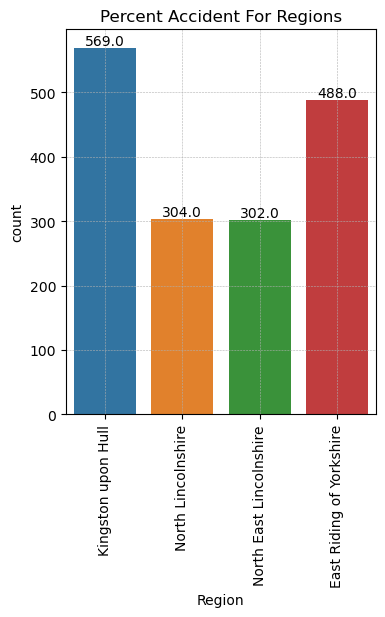

In [143]:
countplot_func(data=accident_data2,main_data=accident_data2,plot_size=(4,5),xlabel='Region',
               plot_title='Percent Accident For Regions',plot_variable='Region',add_count=True,xticks=90)

- More accidents occurred in kingston upon Hull compared to the surrounding areas.

In [144]:
accident_data2.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020160914930           2020          160914930                  3   
1  2020160918418           2020          160918418                  3   
2  2020160936879           2020          160936879                  3   
3  2020160947046           2020          160947046                  3   
4  2020160951627           2020          160951627                  2   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.393424  53.744936                    E06000010                   2   
1  -0.400627  53.744520                    E06000010                   2   
2  -0.400523  53.744482                    E06000010                   2   
3  -0.393720  53.744724                    E06000010                   1   
4  -0.398868  53.744514                    E06000010                   2   

   number_of_casualties       date  day_of_week   time  road_type  \
0                     1 2020-01-02            5  11:20          6   
1                     1 2020-01-13            2  08:00          3   
2                     1 2020-02-17            2  17:20          6   
3                     1 2020-01-03            6  19:00          3   
4                     1 2020-05-16            7  19:40          3   

   speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0           30                   1                    1                 1   
1           30                   1                    1                 1   
2           30                   1                    1                 4   
3           30                   1                    1                 4   
4           30                   1                    1                 1   

  lsoa_of_accident_location Month              Region  
0                 E01012777   Jan  Kingston upon Hull  
1                 E01012777   Jan  Kingston upon Hull  
2                 E01012777   Feb  Kingston upon Hull  
3                 E01012777   Jan  Kingston upon Hull  
4                 E01012777   May  Kingston upon Hull

In [145]:
# Renaming region name for simplicity:
region_list = []
for region in accident_data2['Region']:
    if str(region).startswith('Kingston'):
        region_list.append('Kings_Hull')
    elif str(region).startswith('North Lincolnshire'):
        region_list.append('North_Linc')
    elif region == 'North East Lincolnshire':
        region_list.append('N_EastLinc')
    else:
        region_list.append('East_York')

In [146]:
accident_data2['Area'] = region_list

### Clustering

In [147]:
cluster_data = accident_data2[['longitude','latitude']]
cluster_data.head()

longitude   latitude
0  -0.393424  53.744936
1  -0.400627  53.744520
2  -0.400523  53.744482
3  -0.393720  53.744724
4  -0.398868  53.744514

### Creating a Class object for Clustering Tasks:

In [148]:
class Clustering:
    
    # Function to evaluate KMeans
    def internal_measure_KMeans(data,k):
        '''
        Used for evaluating KMeans performance.
        data: Dataframe
        k: No of clusters in integers
        '''
        kmeans = KMeans(n_clusters=k,n_init='auto',random_state=42)
        clusters = kmeans.fit_predict(data)
        # Calculate the Davies-Bouldin index:
        db_score = davies_bouldin_score(data,clusters)

        # Calculate the Silhouette coefficient:
        s_score = silhouette_score(data,clusters)

        # Calculate Calinski Harabasz Score:
        c_score = calinski_harabasz_score(data,clusters)

        internal_measure_df = pd.DataFrame({'Davies-Bouldin Index':f'{db_score:.3f}','Silhouette Coeff':f'{s_score:.3f}',\
                                           'Calinski Harabasz Score':f'{c_score:.3f}'},index=['Result'])
        return internal_measure_df
    
    # Function to evaluate KMedoids
    def internal_measure_KMedoids(data,k):
        '''
        Used for evaluating KMeans performance.
        data: Dataframe
        k: No of clusters in integers
        '''
        kmed = KMedoids(n_clusters=k,random_state=42)
        clusters = kmed.fit_predict(data)
        # Calculate the Davies-Bouldin index:
        db_score = davies_bouldin_score(data,clusters)

        # Calculate the Silhouette coefficient:
        s_score = silhouette_score(data,clusters)

        # Calculate Calinski Harabasz Score:
        c_score = calinski_harabasz_score(data,clusters)

        internal_measure_df = pd.DataFrame({'Davies-Bouldin Index':f'{db_score:.3f}','Silhouette Coeff':f'{s_score:.3f}',\
                                           'Calinski Harabasz Score':f'{c_score:.3f}'},index=['Result'])
        return internal_measure_df
    
    # Function to visualize clusters:
    def geographic_clusters(data, algorithm):
        cluster_list = []
        for i in range(algorithm.n_clusters):
            loc_cluster_list = data[['latitude', 'longitude']].loc[data['Clusters']==i].values.tolist()
            cluster_list.append(loc_cluster_list)

        loc_map = folium.Map(location=[53.85,-0.1], zoom_start=9)
        for clusters,color in zip(cluster_list,['red','purple','orange','blue','green']):
            for i  in clusters:
                folium.CircleMarker(i, radius=1,color=color).add_to(loc_map)
        return loc_map

In [149]:
# Rescaling the data:
scaler = MinMaxScaler()
scaled_data  = scaler.fit_transform(cluster_data)
scaled_data_df = pd.DataFrame(scaled_data, columns=cluster_data.columns)

In [150]:
scaled_data_df.head()

longitude  latitude
0   0.561509  0.419494
1   0.555402  0.418889
2   0.555490  0.418833
3   0.561258  0.419186
4   0.556893  0.418880

### Applying KMeans Clustering

In [151]:
Db_score = []
sil_coeff = []
range_ = range(2,15)
for n_clusters in range_:
    df = Clustering.internal_measure_KMeans(data=scaled_data, k=n_clusters)
    Db_score.append(df.loc['Result','Davies-Bouldin Index'])
    sil_coeff.append(df.loc['Result','Silhouette Coeff'])
performance_df = pd.DataFrame({'No of Clusters(k)':range_,'Db_Score':Db_score,'Sil_coeff':sil_coeff})

performance_df['Db_Score'] = performance_df['Db_Score'].astype(float)
performance_df['Sil_coeff'] = performance_df['Sil_coeff'].astype(float)

performance_df

No of Clusters(k)  Db_Score  Sil_coeff
0                   2     0.733      0.442
1                   3     0.648      0.564
2                   4     0.632      0.619
3                   5     0.572      0.650
4                   6     0.655      0.566
5                   7     0.645      0.582
6                   8     0.677      0.572
7                   9     0.686      0.528
8                  10     0.649      0.556
9                  11     0.674      0.499
10                 12     0.692      0.491
11                 13     0.673      0.503
12                 14     0.692      0.500

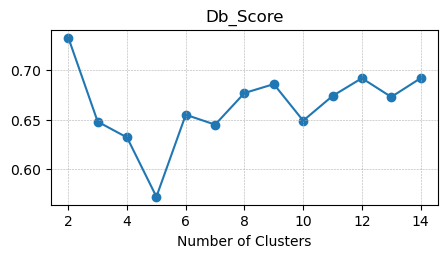

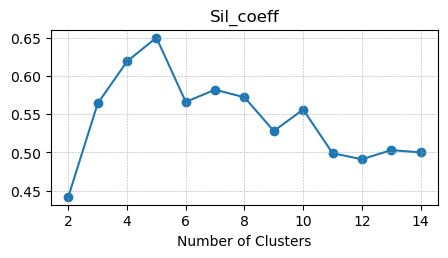

In [152]:
for feature in performance_df.drop('No of Clusters(k)',axis=1):
    i=0
    plt.figure(figsize=(5,5))
    plt.subplot(2,1,i+1)
    plt.scatter(data=performance_df, x='No of Clusters(k)', y=feature)
    plt.plot(performance_df['No of Clusters(k)'],performance_df[feature])
    plt.title(feature)
    plt.xlabel('Number of Clusters')
    plt.grid(linestyle='--',linewidth=0.4)
    i=i+1
    plt.show()

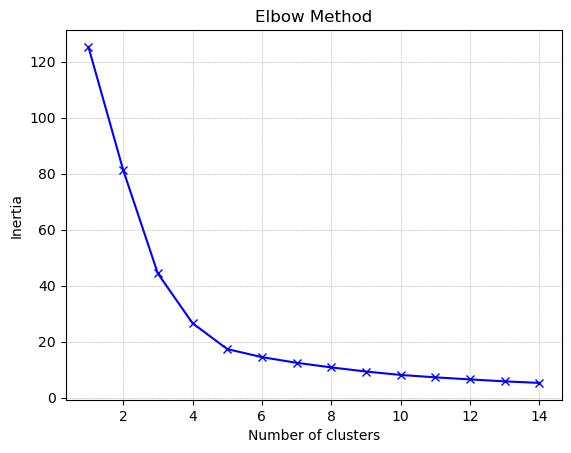

In [153]:
# Attempting Elbow Method to determine number of clusters:
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    distortions.append(kmeans.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(linestyle='--',linewidth=0.4)
plt.show()

In [156]:
Clustering.internal_measure_KMeans(data=scaled_data, k=5)

Davies-Bouldin Index Silhouette Coeff Calinski Harabasz Score
Result                0.572            0.650                2581.436

In [157]:
kmeans = KMeans(n_clusters=5, random_state=0,n_init='auto')
clusters = kmeans.fit_predict(cluster_data)
clusters

array([4, 4, 4, ..., 4, 4, 4])

In [158]:
clusters_df = pd.DataFrame(clusters, columns=['Clusters'])
clusters_df

Clusters
0            4
1            4
2            4
3            4
4            4
...        ...
1658         2
1659         4
1660         4
1661         4
1662         4

[1663 rows x 1 columns]

In [159]:
#Adding clusters to dataframe:
new_cluster_df = pd.concat([cluster_data, clusters_df], axis=1)
new_cluster_df

longitude   latitude  Clusters
0     -0.393424  53.744936         4
1     -0.400627  53.744520         4
2     -0.400523  53.744482         4
3     -0.393720  53.744724         4
4     -0.398868  53.744514         4
...         ...        ...       ...
1658  -0.823599  53.520707         2
1659  -0.196631  53.741804         4
1660  -0.318108  53.773648         4
1661  -0.408728  53.843568         4
1662  -0.428826  53.743858         4

[1663 rows x 3 columns]

### Geographic Clustering Based on Location (KMeans):

In [160]:
kmeans.cluster_centers_

array([[-0.09147249, 53.57621063],
       [-0.2715766 , 54.0433033 ],
       [-0.64717868, 53.58547258],
       [-0.8177225 , 53.80799228],
       [-0.36222849, 53.75941016]])

In [161]:
new_cluster_df

longitude   latitude  Clusters
0     -0.393424  53.744936         4
1     -0.400627  53.744520         4
2     -0.400523  53.744482         4
3     -0.393720  53.744724         4
4     -0.398868  53.744514         4
...         ...        ...       ...
1658  -0.823599  53.520707         2
1659  -0.196631  53.741804         4
1660  -0.318108  53.773648         4
1661  -0.408728  53.843568         4
1662  -0.428826  53.743858         4

[1663 rows x 3 columns]

In [162]:
cluster_list = []
for i in range(kmeans.n_clusters):
    loc_cluster_list = new_cluster_df[['latitude', 'longitude']].loc[new_cluster_df['Clusters']==i].values.tolist()
    cluster_list.append(loc_cluster_list)

In [163]:
image_map = Clustering.geographic_clusters(data=new_cluster_df, algorithm=kmeans)
image_map

- Green = Cluster 5
- Orange = Cluster 3
- Purple = Cluster 2
- Red = Cluster 4
- Blue = 1

- Most of the accients in North Lincolnshire happened within Scunthorpe area and belong to cluster group 3
- Accidents in East of Yorkshire were sparsely distributed into 4 cluster group. However ther seemed to be a concentration of accidents more in Goole, Beverley, Driffield and Bridlington in 2020.
- Four accidents happened on the Humber bridge and they belong to cluster 5. This should be looked into because accidents on the bridge poses a lot of dangers to other users of the bridge.

In [164]:
# Saving the map with clusters:
image_map.save('clusters_live_map1.html')

In [165]:
accident_data2['Clusters'] = new_cluster_df['Clusters']

<Figure size 640x480 with 0 Axes>

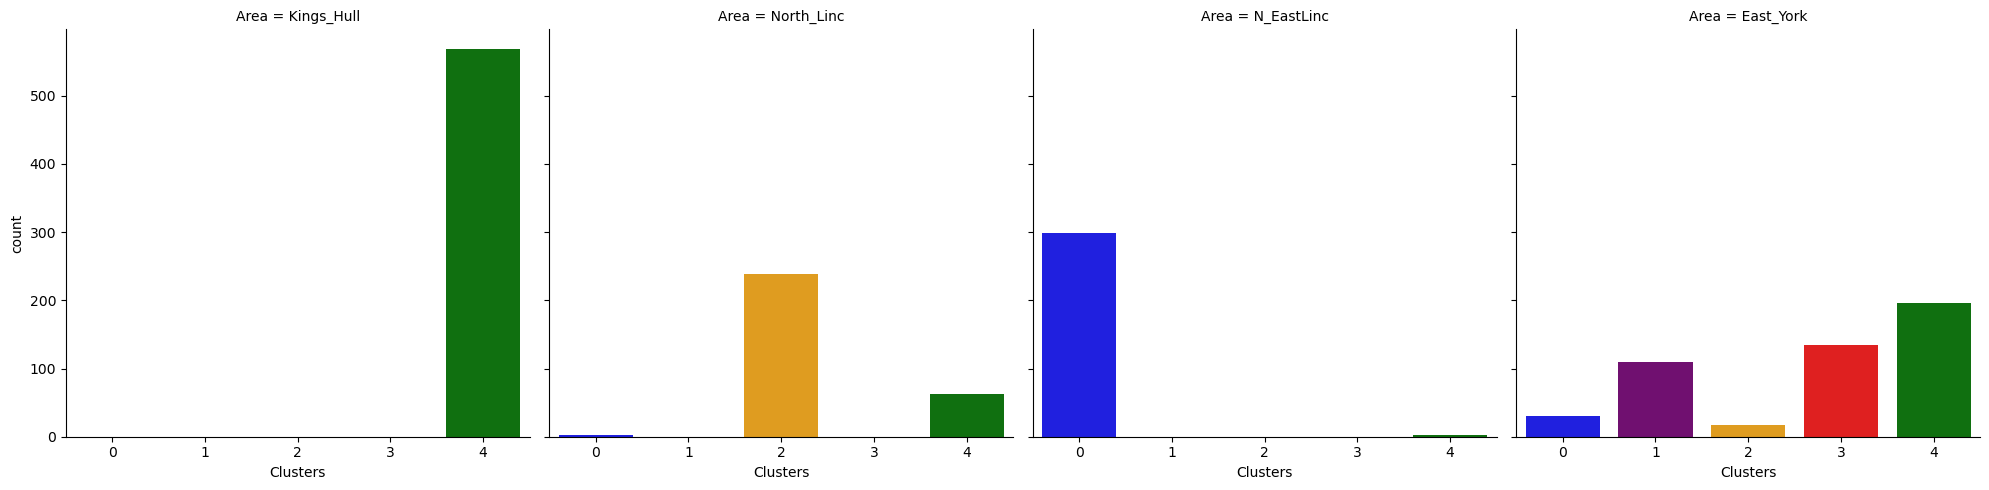

In [166]:
plt.figure(dpi=100)
sns.catplot(data=accident_data2, x='Clusters', col='Area',kind='count', palette=sns.color_palette(['blue','purple','orange','red','green']))
plt.show()

KMedoid:

In [167]:
Db_score = []
sil_coeff = []
range_ = range(2,15)
for n_clusters in range_:
    df = Clustering.internal_measure_KMedoids(data=scaled_data, k=n_clusters)
    Db_score.append(df.loc['Result','Davies-Bouldin Index'])
    sil_coeff.append(df.loc['Result','Silhouette Coeff'])
performance_df = pd.DataFrame({'No of Clusters(k)':range_,'Db_Score':Db_score,'Sil_coeff':sil_coeff})

performance_df['Db_Score'] = performance_df['Db_Score'].astype(float)
performance_df['Sil_coeff'] = performance_df['Sil_coeff'].astype(float)

performance_df

No of Clusters(k)  Db_Score  Sil_coeff
0                   2     0.854      0.430
1                   3     0.641      0.566
2                   4     0.623      0.618
3                   5     0.868      0.413
4                   6     1.022      0.392
5                   7     0.717      0.475
6                   8     0.711      0.470
7                   9     0.759      0.445
8                  10     0.783      0.411
9                  11     0.878      0.388
10                 12     0.851      0.399
11                 13     0.858      0.413
12                 14     0.875      0.375

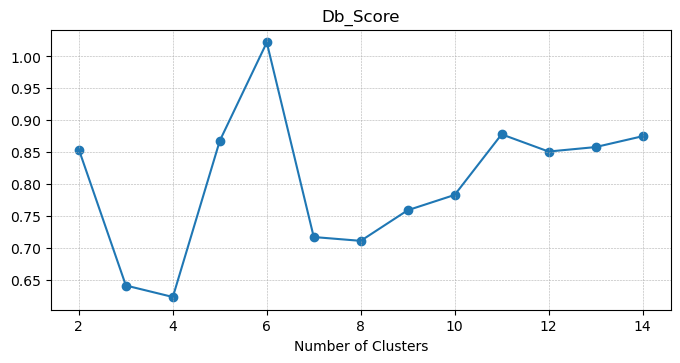

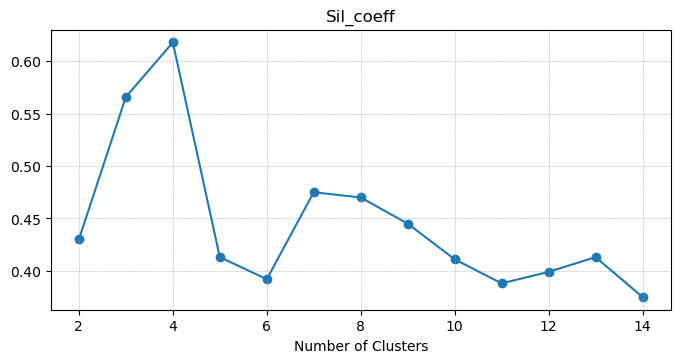

In [168]:
for feature in performance_df.drop('No of Clusters(k)',axis=1):
    i=0
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,i+1)
    plt.scatter(data=performance_df, x='No of Clusters(k)', y=feature)
    plt.plot(performance_df['No of Clusters(k)'],performance_df[feature])
    plt.title(feature)
    plt.xlabel('Number of Clusters')
    plt.grid(linestyle='--',linewidth=0.4)
    i=i+1
    plt.show()

In [171]:
Clustering.internal_measure_KMedoids(data=scaled_data, k=4)

Davies-Bouldin Index Silhouette Coeff Calinski Harabasz Score
Result                0.623            0.618                2042.147

In [172]:
kmed = KMedoids(n_clusters=4, random_state=42)
clusters = kmed.fit_predict(cluster_data)
clusters_df = pd.DataFrame(clusters, columns=['Clusters'])
#Adding clusters to dataframe:
new_cluster_df = pd.concat([cluster_data, clusters_df], axis=1)
new_cluster_df

longitude   latitude  Clusters
0     -0.393424  53.744936         2
1     -0.400627  53.744520         2
2     -0.400523  53.744482         2
3     -0.393720  53.744724         2
4     -0.398868  53.744514         2
...         ...        ...       ...
1658  -0.823599  53.520707         0
1659  -0.196631  53.741804         1
1660  -0.318108  53.773648         1
1661  -0.408728  53.843568         2
1662  -0.428826  53.743858         2

[1663 rows x 3 columns]

In [173]:
Clustering.geographic_clusters(data=new_cluster_df, algorithm=kmed)

## Question 6:
### Outlier Detection
#### Inter-Quantile Range Method

In [174]:
entry_df = accident_copy[['longitude','latitude']]
veh_df = veh_df[['age_of_driver','age_of_vehicle']]

In [175]:
class Outlier_detection:
    
    def outlier_detection(data):
        def entry_limit1(data, col):
            q1, q3 = np.quantile(data[col].astype(float),0.25), np.quantile(data[col].astype(float),0.75)
            IQR = q3 - q1
            upper = q3 + 1.5 * IQR
            lower = q1 - 1.5 * IQR
            return round(upper, 2), round(lower, 2)
    
        column_name = []
        percent_upper = []
        percent_lower = []
        UL_val = []
        LL_val = []
        total_outliers_percent = []
        for col in data.columns:
            column_name.append(col)

            UL,LL = entry_limit1(data, col)
            UL_val.append(UL)
            LL_val.append(LL)
            percent_upper.append(round((len(data[data[col]>UL])/len(data) * 100),2))
            percent_lower.append(round((len(data[data[col]<LL])/len(data) * 100),2))

        total_outliers_percent = np.add(percent_upper, percent_lower)

        data = pd.DataFrame({'Feature':column_name, 'Upper_Whisk':UL_val,'Lower_Whisk':LL_val,
                            'Upper(%)':percent_upper,'Lower(%)':percent_lower,'Total(%)':total_outliers_percent})
        return data

In [176]:
# Excluding null entries:
veh_df = veh_df[(veh_df['age_of_driver'].notnull()) & (veh_df['age_of_vehicle'].notnull())]
veh_df

age_of_driver  age_of_vehicle
0                32.0             6.0
1                45.0             2.0
3                44.0             8.0
4                20.0             4.0
5                25.0             5.0
...               ...             ...
167369           39.0             7.0
167370           57.0             2.0
167371           38.0             2.0
167372           68.0             1.0
167374           39.0             2.0

[121103 rows x 2 columns]

In [177]:
Outlier_detection.outlier_detection(data=veh_df)

Feature  Upper_Whisk  Lower_Whisk  Upper(%)  Lower(%)  Total(%)
0   age_of_driver         90.0        -14.0      0.13       0.0      0.13
1  age_of_vehicle         24.0         -8.0      0.57       0.0      0.57

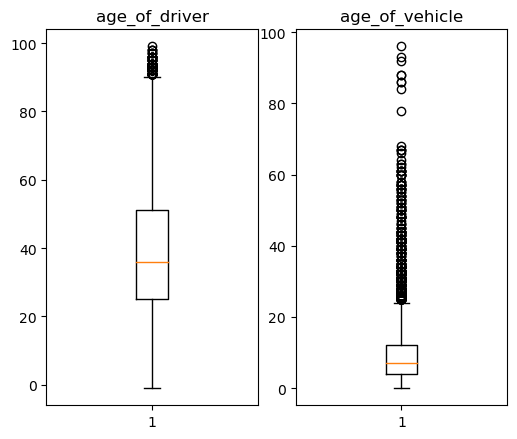

In [178]:
#Checking the outliers:
plt.figure(figsize=(5,8))
for features,entry in zip(veh_df.columns,range(0,len(veh_df.columns))):
    plt.subplot(2,2,entry+1)
    plt.boxplot(veh_df[features])
    plt.title(features)
plt.tight_layout(pad=0.1)
plt.show()

Outlier detected:
- Cars about 25 years and above.
- Drivers about 90 years and above.

## Question 7

Building an a classification model to predict the severity of an accident.

Algorithms used: Logistic Regression, Decision Tree Classifier and K-Nearest Neighbor Classifier.

In [179]:
# creating an instance of the algorithms:
log = LogisticRegression()
d_tree = DecisionTreeClassifier()
k_nn = KNeighborsClassifier()

In [180]:
accident_copy.head()

accident_index  accident_year accident_reference  accident_severity  \
0  2020010219808           2020          010219808                  3   
1  2020010220496           2020          010220496                  3   
2  2020010228005           2020          010228005                  3   
3  2020010228006           2020          010228006                  2   
4  2020010228011           2020          010228011                  3   

   longitude   latitude local_authority_ons_district  number_of_vehicles  \
0  -0.254001  51.462262                    E09000032                   1   
1  -0.139253  51.470327                    E09000022                   1   
2  -0.178719  51.529614                    E09000033                   1   
3  -0.001683  51.541210                    E09000025                   1   
4  -0.137592  51.515704                    E09000033                   1   

   number_of_casualties       date  day_of_week   time  road_type  \
0                     1 2020-02-04            3  09:00          6   
1                     2 2020-04-27            2  13:55          6   
2                     1 2020-01-01            4  01:25          6   
3                     1 2020-01-01            4  01:50          6   
4                     2 2020-01-01            4  02:25          6   

   speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
0           20                   9                    1                 1   
1           20                   1                    1                 1   
2           30                   1                    1                 4   
3           30                   1                    1                 4   
4           30                   1                    1                 4   

  lsoa_of_accident_location Month  
0                 E01004576   Feb  
1                 E01003034   Apr  
2                 E01004726   Jan  
3                 E01003617   Jan  
4                 E01004763   Jan

In [181]:
# Excluding objects from data:
accident_df.select_dtypes(include='number')

accident_year  location_easting_osgr  location_northing_osgr  \
0               2020               521389.0                175144.0   
1               2020               529337.0                176237.0   
2               2020               526432.0                182761.0   
3               2020               538676.0                184371.0   
4               2020               529324.0                181286.0   
...              ...                    ...                     ...   
91194           2020               343034.0                731654.0   
91195           2020               257963.0                658891.0   
91196           2020               383664.0                810646.0   
91197           2020               277161.0                674852.0   
91198           2020               240402.0                681950.0   

       longitude   latitude  police_force  accident_severity  \
0      -0.254001  51.462262             1                  3   
1      -0.139253  51.470327             1                  3   
2      -0.178719  51.529614             1                  3   
3      -0.001683  51.541210             1                  2   
4      -0.137592  51.515704             1                  3   
...          ...        ...           ...                ...   
91194  -2.926320  56.473539            99                  2   
91195  -4.267565  55.802353            99                  3   
91196  -2.271903  57.186317            99                  2   
91197  -3.968753  55.950940            99                  3   
91198  -4.561040  56.003843            99                  3   

       number_of_vehicles  number_of_casualties  day_of_week  \
0                       1                     1            3   
1                       1                     2            2   
2                       1                     1            4   
3                       1                     1            4   
4                       1                     2            4   
...                   ...                   ...          ...   
91194                   2                     1            4   
91195                   1                     1            6   
91196                   2                     1            4   
91197                   2                     1            3   
91198                   1                     1            3   

       local_authority_district  first_road_class  first_road_number  \
0                            10                 6                  0   
1                             9                 3               3036   
2                             1                 5                  0   
3                            17                 3                 11   
4                             1                 3                 40   
...                         ...               ...                ...   
91194                       918                 4                959   
91195                       922                 6                  0   
91196                       910                 4                979   
91197                       932                 6                  0   
91198                       916                 6                  0   

       road_type  speed_limit  junction_detail  junction_control  \
0              6           20                0                -1   
1              6           20                9                 2   
2              6           30                3                 1   
3              6           30                0                -1   
4              6           30                3                 4   
...          ...          ...              ...               ...   
91194          6           30                1                 4   
91195          9           30                3                 4   
91196          6           60                8                -1   
91197          6           30                3                 4   
911

In [182]:
# Dropping Accident year:
select_data = accident_copy.select_dtypes(include='number')
select_data.drop('accident_year', axis=1, inplace=True)
select_data.head()

accident_severity  longitude   latitude  number_of_vehicles  \
0                  3  -0.254001  51.462262                   1   
1                  3  -0.139253  51.470327                   1   
2                  3  -0.178719  51.529614                   1   
3                  2  -0.001683  51.541210                   1   
4                  3  -0.137592  51.515704                   1   

   number_of_casualties  day_of_week  road_type  speed_limit  \
0                     1            3          6           20   
1                     2            2          6           20   
2                     1            4          6           30   
3                     1            4          6           30   
4                     2            4          6           30   

   weather_conditions  urban_or_rural_area  light_conditions  
0                   9                    1                 1  
1                   1                    1                 1  
2                   1                    1                 4  
3                   1                    1                 4  
4                   1                    1                 4

Filtering severity into 1 and 2 where 1 = fatal and 2 = non fatal.

In [183]:
catalogue[catalogue['field name']=='accident_severity']

table         field name code/format    label note
59  Accident  accident_severity           1    Fatal  NaN
60  Accident  accident_severity           2  Serious  NaN
61  Accident  accident_severity           3   Slight  NaN

In [184]:
# Replacing severity with 1 (fatal) and 0 (non fatal):
label = []
for severity in accident_copy['accident_severity']:
    if severity == 1:
        label.append(1)
    else:
        label.append(0)
select_data['severity'] = label
select_data.drop('accident_severity', axis=1, inplace=True)
select_data.head()

longitude   latitude  number_of_vehicles  number_of_casualties  \
0  -0.254001  51.462262                   1                     1   
1  -0.139253  51.470327                   1                     2   
2  -0.178719  51.529614                   1                     1   
3  -0.001683  51.541210                   1                     1   
4  -0.137592  51.515704                   1                     2   

   day_of_week  road_type  speed_limit  weather_conditions  \
0            3          6           20                   9   
1            2          6           20                   1   
2            4          6           30                   1   
3            4          6           30                   1   
4            4          6           30                   1   

   urban_or_rural_area  light_conditions  severity  
0                    1                 1         0  
1                    1                 1         0  
2                    1                 4         0  
3                    1                 4         0  
4                    1                 4         0

In [185]:
accident_copy['speed_limit'].unique()

array([20, 30, 40, 50, 60, 70])

In [186]:
# Replacing severity with 1 (fatal) and 0 (non fatal):
speed_new = []
for limit in accident_copy['speed_limit']:
    if limit == 20:
        speed_new.append(1)
    elif limit ==30:
        speed_new.append(2)
    elif limit ==40:
        speed_new.append(3)
    elif limit ==50:
        speed_new.append(4)
    elif limit ==60:
        speed_new.append(5)
    else:
        speed_new.append(6)
select_data['speed_limit'] = speed_new
select_data.head()

longitude   latitude  number_of_vehicles  number_of_casualties  \
0  -0.254001  51.462262                   1                     1   
1  -0.139253  51.470327                   1                     2   
2  -0.178719  51.529614                   1                     1   
3  -0.001683  51.541210                   1                     1   
4  -0.137592  51.515704                   1                     2   

   day_of_week  road_type  speed_limit  weather_conditions  \
0            3          6            1                   9   
1            2          6            1                   1   
2            4          6            2                   1   
3            4          6            2                   1   
4            4          6            2                   1   

   urban_or_rural_area  light_conditions  severity  
0                    1                 1         0  
1                    1                 1         0  
2                    1                 4         0  
3                    1                 4         0  
4                    1                 4         0

### Checking for Imbalance in the target feature:

In [187]:
fatal_df = select_data[select_data['severity']==1]
non_fatal_df = select_data[select_data['severity']==0]
print(f'There are {fatal_df.shape[0]} fatal accidents.')
print(f'There are {non_fatal_df.shape[0]} non-fatal accidents.')

There are 1391 fatal accidents.
There are 89808 non-fatal accidents.


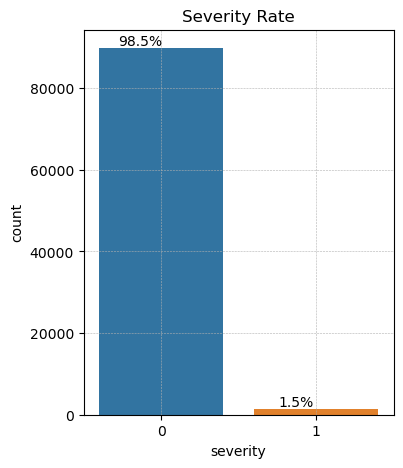

In [188]:
countplot_func(data=select_data,main_data=select_data,plot_size=(4,5),xlabel='severity',
               plot_title='Severity Rate',plot_variable='severity',add_count=False,xticks=None)

- Data imbalanced.

### Balancing the Data

In [189]:
select_feature = select_data.drop('severity',axis=1)
target = select_data['severity']

Implementing SMOTE-NC (SMOTE variant for both categorical and continous data features)

- Categorical variables in the data are found at column index 4 to 9. This will be applied to the SMOTENC categorical features.

In [190]:
sm_nc = SMOTENC(categorical_features=range(4,10), random_state=42)
bal_indepen, y_label_bal = sm_nc.fit_resample(select_feature, target)

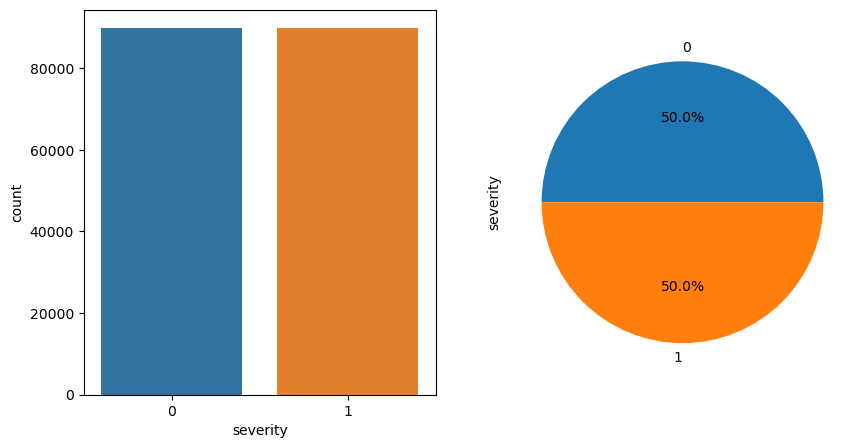

In [191]:
# Visualizing the balanced data:
balance = pd.concat([bal_indepen,y_label_bal], axis = 1) # creating a dataframe for the balanced data
fig, position = plt.subplots(1,2,figsize=(10,5))
plot = sns.countplot(x='severity',data=balance, ax=position[0])
plot = balance['severity'].value_counts().plot.pie(autopct="%1.1f%%", ax=position[1])

- Data balanced.

### Model Building:

#### Defining functions for building and evaluating model performance:

In [192]:
# Building Model:
def building_model(model,Xtrain_data,X_data,Ytrain_data):
    model.fit(Xtrain_data,Ytrain_data)
    prediction = model.predict(X_data)
    return prediction

# Evaluating model:
def performance_evaluation(prediction_test,prediction_val,prediction_train,Yval_data,Ytest_data,Ytrain_data):
    
    #Training:
    prec_train = precision_score(Ytrain_data,prediction_train)
    accu_train = accuracy_score(Ytrain_data,prediction_train)
    rec_train = recall_score(Ytrain_data,prediction_train)
    f1_train = f1_score(Ytrain_data,prediction_train)
    
    #Validation:    
    prec_val = precision_score(Yval_data,prediction_val)
    accu_val = accuracy_score(Yval_data,prediction_val)
    rec_val = recall_score(Yval_data,prediction_val)
    f1_val = f1_score(Yval_data,prediction_val)
    
    #Testing:    
    prec_test = precision_score(Ytest_data,prediction_test)
    accu_test = accuracy_score(Ytest_data,prediction_test)
    rec_test = recall_score(Ytest_data,prediction_test)
    f1_test = f1_score(Ytest_data,prediction_test)
    
    #Performance Dataframe:
    perform_eval = pd.DataFrame({'Precision':[f'{prec_train:.2f}',f'{prec_val:.2f}',f'{prec_test:.2f}'],\
                                 'Recall':[f'{rec_train:.2f}',f'{rec_val:.2f}',f'{rec_test:.2f}'],\
                                 'F1 Score':[f'{f1_train:.2f}',f'{f1_val:.2f}',f'{f1_test:.2f}'],\
                               'Accuracy':[f'{accu_train:.2f}',f'{accu_val:.2f}',f'{accu_test:.2f}']},\
                                index=['Training','Validation','Testing'])
    return perform_eval

# Classification report function:
def classification_summary(yTrain,yTest,yVal,yPrediction_train,yPrediction_test,yPrediction_val):
    print('Classification Report for Training:')
    print(classification_report(yTrain, yPrediction_train))
    print('='*80)
    print('Classification Report for Testing:')
    print(classification_report(yVal, yPrediction_val))
    print('='*80)
    print('Classification Report for Testing:')
    print(classification_report(yTest, yPrediction_test))
    print('='*80)

# Confusion matrix function:
def classification_confusion_matrix(fig,yTest,yVal,yTrain,yPrediction_train,yPrediction_val,yPrediction_test,display_labels):
    fig, ax = plt.subplots(1,3,figsize=fig)
    ConfusionMatrixDisplay.from_predictions(yTrain,yPrediction_train, display_labels=display_labels,ax=ax[0])
    ConfusionMatrixDisplay.from_predictions(yVal,yPrediction_val, display_labels=display_labels,ax=ax[1])
    ConfusionMatrixDisplay.from_predictions(yTest,yPrediction_test, display_labels=display_labels,ax=ax[2])
    ax[0].title.set_text('Training')
    ax[1].title.set_text('Validation')
    ax[2].title.set_text('Testing')
    plt.tight_layout(pad=0.2)
    plt.show()
    return

### Feature selection using Recursive Feature Elimination (RFE) Method:

In [193]:
#Creating an instance of the RFE model:
model = DecisionTreeClassifier()
r_feature_elim = RFE(model, n_features_to_select=8)

X = bal_indepen
y = y_label_bal

#Training the model
model = r_feature_elim.fit(X,y)

#Outputing booleans to identify features:
print(model.support_)

[ True  True  True  True  True  True  True  True False False]


In [194]:
#Outputting the best 8 features (All feature corrsponding to the 'True' from model.support_):
X_new = np.array(X.columns)[model.support_]
print(X_new)

['longitude' 'latitude' 'number_of_vehicles' 'number_of_casualties'
 'day_of_week' 'road_type' 'speed_limit' 'weather_conditions']


In [195]:
#Separating the dependent and independent variables:
X = bal_indepen[X_new]  #Using the selected variables from RFE method
y = y_label_bal

# Splitting data into training, validation and testing data:
X_, X_test, y_, y_test = train_test_split(X,y, test_size=0.3,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_,y_, test_size=0.3,random_state=42)

# Normalizing the data:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

#### Applying Logistic Regression:

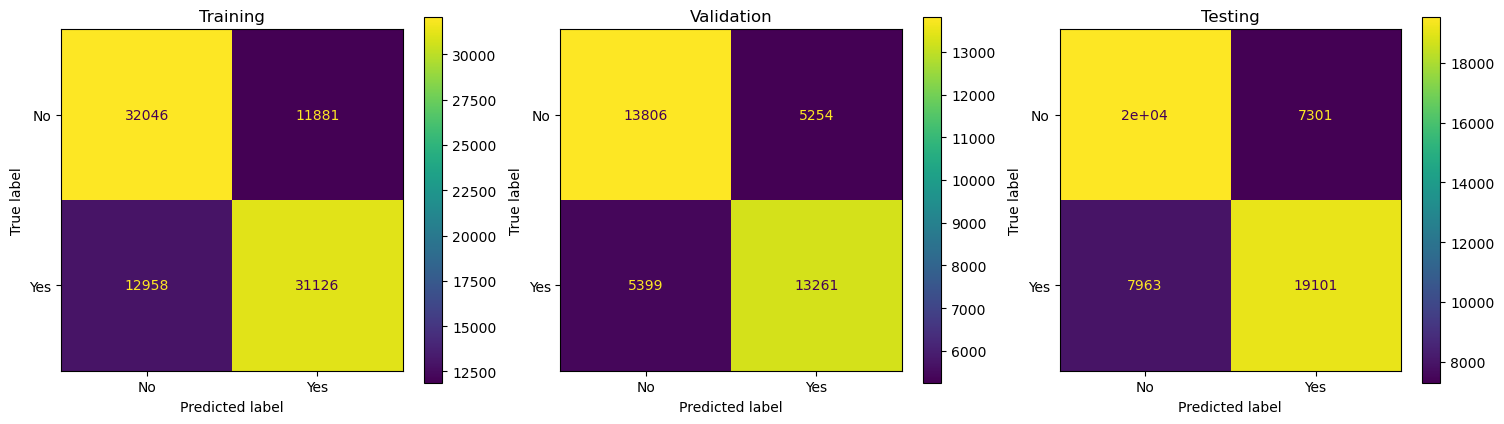

Precision Recall F1 Score Accuracy
Training        0.72   0.71     0.71     0.72
Validation      0.72   0.71     0.71     0.72
Testing         0.72   0.71     0.71     0.72

In [196]:
#Training Prediction:
prediction_train = building_model(model=log,Xtrain_data=X_train_s,X_data=X_train_s,Ytrain_data=y_train)

#Testing Prediction:
prediction_val = building_model(model=log,Xtrain_data=X_train_s,X_data=X_val_s,Ytrain_data=y_train)

#Testing Prediction:
prediction_test = building_model(model=log,Xtrain_data=X_train_s,X_data=X_test_s,Ytrain_data=y_train)

#Confusion Matrix for both Training and Testing:
classification_confusion_matrix(fig=(15,4),yTest=y_test,yVal=y_val,yTrain=y_train,yPrediction_train=prediction_train,
                                yPrediction_val=prediction_val,yPrediction_test=prediction_test,
                                display_labels=['No', 'Yes'])

#Performance Metric Evaluation:
performance_evaluation(prediction_val=prediction_val,prediction_test=prediction_test,prediction_train=prediction_train,
                       Ytest_data=y_test,Ytrain_data=y_train,Yval_data=y_val)

#### Applying Decision Tree Classifier:

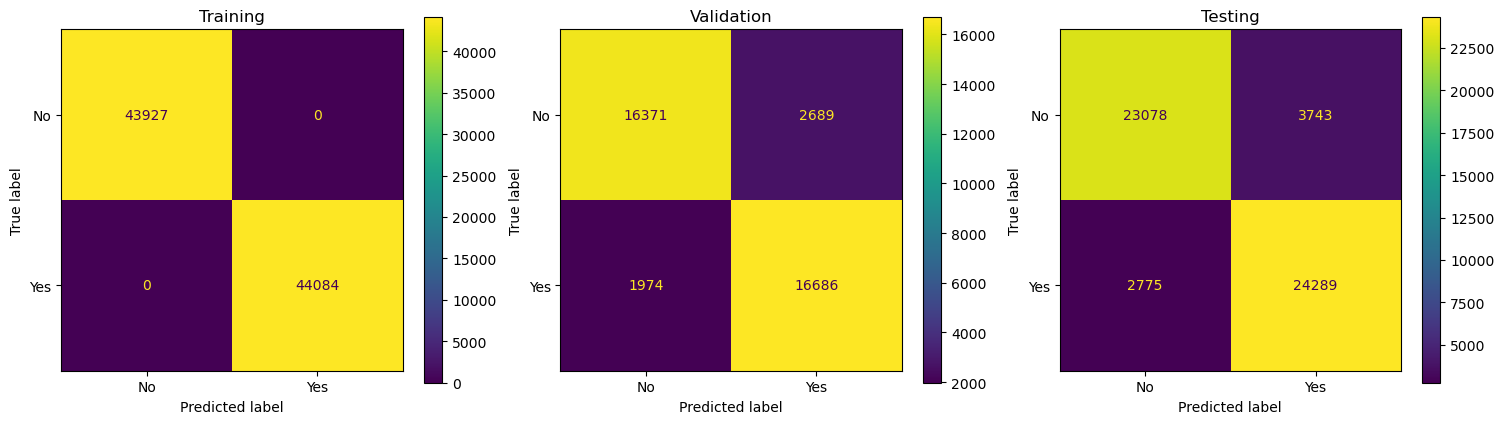

Precision Recall F1 Score Accuracy
Training        1.00   1.00     1.00     1.00
Validation      0.86   0.89     0.88     0.88
Testing         0.87   0.90     0.88     0.88

In [197]:
#Training Prediction:
prediction_train = building_model(model=d_tree,Xtrain_data=X_train_s,X_data=X_train_s,Ytrain_data=y_train)

#Testing Prediction:
prediction_val = building_model(model=d_tree,Xtrain_data=X_train_s,X_data=X_val_s,Ytrain_data=y_train)

#Testing Prediction:
prediction_test = building_model(model=d_tree,Xtrain_data=X_train_s,X_data=X_test_s,Ytrain_data=y_train)

#Confusion Matrix for both Training and Testing:
classification_confusion_matrix(fig=(15,4),yTest=y_test,yVal=y_val,yTrain=y_train,yPrediction_train=prediction_train,
                                yPrediction_val=prediction_val,yPrediction_test=prediction_test,
                                display_labels=['No', 'Yes'])

#Performance Metric Evaluation:
performance_evaluation(prediction_val=prediction_val,prediction_test=prediction_test,prediction_train=prediction_train,
                       Ytest_data=y_test,Ytrain_data=y_train,Yval_data=y_val)

In [198]:
from sklearn.model_selection import GridSearchCV

#### Applying K-Nearest Neighbor (KNN)

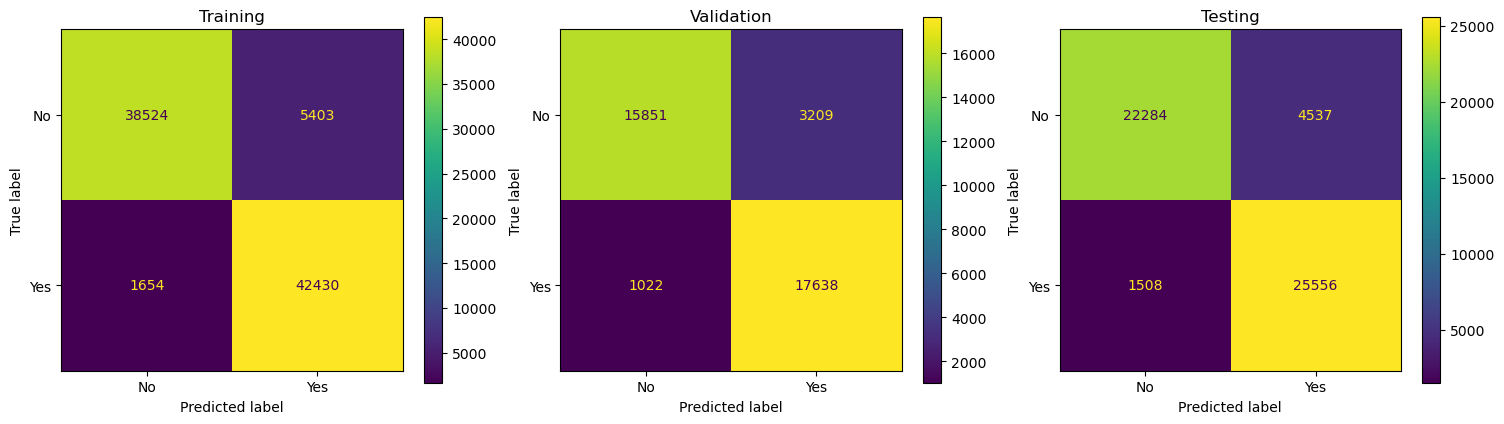

Precision Recall F1 Score Accuracy
Training        0.89   0.96     0.92     0.92
Validation      0.85   0.95     0.89     0.89
Testing         0.85   0.94     0.89     0.89

In [199]:
#Training Prediction:
prediction_train = building_model(model=k_nn,Xtrain_data=X_train_s,X_data=X_train_s,Ytrain_data=y_train)

#Testing Prediction:
prediction_val = building_model(model=k_nn,Xtrain_data=X_train_s,X_data=X_val_s,Ytrain_data=y_train)

#Testing Prediction:
prediction_test = building_model(model=k_nn,Xtrain_data=X_train_s,X_data=X_test_s,Ytrain_data=y_train)

#Confusion Matrix for both Training and Testing:
classification_confusion_matrix(fig=(15,4),yTest=y_test,yVal=y_val,yTrain=y_train,yPrediction_train=prediction_train,
                                yPrediction_val=prediction_val,yPrediction_test=prediction_test,
                                display_labels=['No', 'Yes'])

#Performance Metric Evaluation:
performance_evaluation(prediction_val=prediction_val,prediction_test=prediction_test,prediction_train=prediction_train,
                       Ytest_data=y_test,Ytrain_data=y_train,Yval_data=y_val)

In [200]:
grid_par = {'n_neighbors':range(3,10)}
model = KNeighborsClassifier()
gridCV = GridSearchCV(model, grid_par,cv=10, scoring='recall')
gridCV.fit(X_train_s,y_train)

print("Best Hyperparameters :", gridCV.best_params_)
print("Validation Accuracy :",gridCV.best_score_)

Best Hyperparameters : {'n_neighbors': 5}
Validation Accuracy : 0.9400009992347776


- Scoring method - 'recall' was used to optimize the recall value.

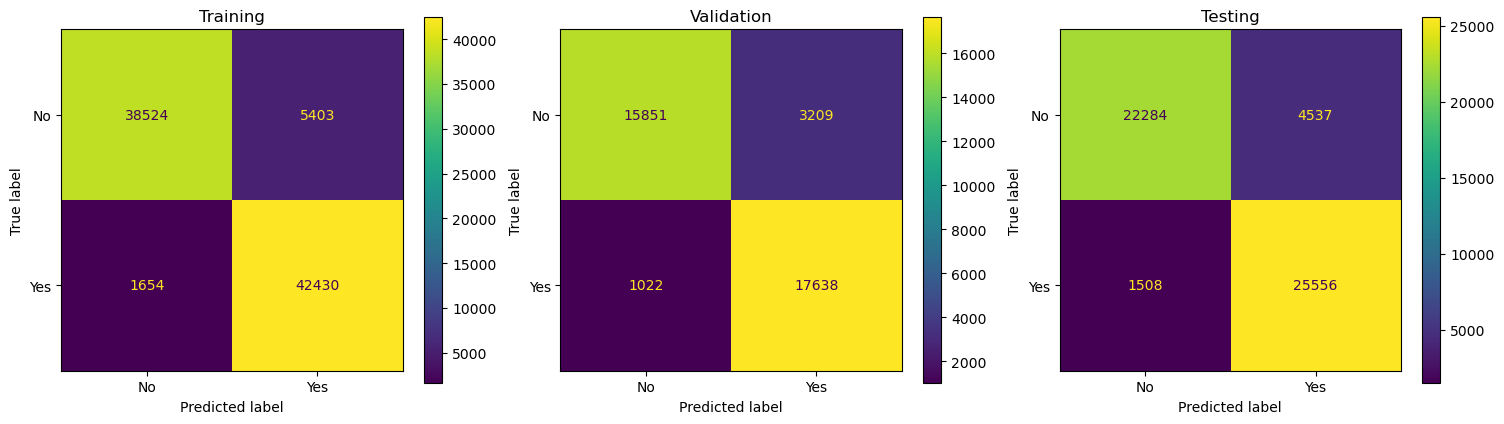

Precision Recall F1 Score Accuracy
Training        0.89   0.96     0.92     0.92
Validation      0.85   0.95     0.89     0.89
Testing         0.85   0.94     0.89     0.89

In [201]:
k_nn2 = KNeighborsClassifier(**gridCV.best_params_)
#Training Prediction:
prediction_train = building_model(model=k_nn2,Xtrain_data=X_train_s,X_data=X_train_s,Ytrain_data=y_train)

#Testing Prediction:
prediction_val = building_model(model=k_nn2,Xtrain_data=X_train_s,X_data=X_val_s,Ytrain_data=y_train)

#Testing Prediction:
prediction_test = building_model(model=k_nn2,Xtrain_data=X_train_s,X_data=X_test_s,Ytrain_data=y_train)

#Confusion Matrix for both Training and Testing:
classification_confusion_matrix(fig=(15,4),yTest=y_test,yVal=y_val,yTrain=y_train,yPrediction_train=prediction_train,
                                yPrediction_val=prediction_val,yPrediction_test=prediction_test,
                                display_labels=['No', 'Yes'])

#Performance Metric Evaluation:
performance_evaluation(prediction_val=prediction_val,prediction_test=prediction_test,prediction_train=prediction_train,
                       Ytest_data=y_test,Ytrain_data=y_train,Yval_data=y_val)

- Model performance remained the same after gridsearchCV.
- KNN model performed better than both logistic regression and decision tree classifier with a precision, recall and accuracy of 89%, 96% and 92%.
- The KNN model perform well on both validaton and test data, hence, generalizes well.

### Further Analysis For Accidents on Humber Bridge:

In [202]:
dataNew = accident_data2[accident_data2['Clusters']==4]
humber = []
test = Nominatim(user_agent='MyHumber')
for a, b in zip(dataNew['latitude'], dataNew['longitude']):
    loca = (str(test.reverse([str(a),str(b)]))).lower()
    if 'humber bridge' in loca:
        humber.append(1)
    else:
        humber.append(0)

In [203]:
humber_bridge_index = []
for i, a in enumerate(humber):
    if a == 1:
        humber_bridge_index.append(i)
    else:
        continue

In [204]:
week_dict

{1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thur', 6: 'Fri', 7: 'Sat'}

In [205]:
day_list1 = []
for week in dataNew['day_of_week']:
    day_list1.append(week_dict[week])
dataNew['day_of_week'] = day_list1

In [206]:
dataNew.reset_index(drop=True, inplace=True)

In [207]:
dataNew.loc[humber_bridge_index]

accident_index  accident_year accident_reference  accident_severity  \
225  2020160975490           2020          160975490                  3   
226  2020160988135           2020          160988135                  3   

     longitude   latitude local_authority_ons_district  number_of_vehicles  \
225  -0.450628  53.713048                    E06000011                   2   
226  -0.450376  53.710402                    E06000011                   2   

     number_of_casualties       date day_of_week   time  road_type  \
225                     1 2020-08-20        Thur  16:20          3   
226                     1 2020-09-30         Wed  17:30          3   

     speed_limit  weather_conditions  urban_or_rural_area  light_conditions  \
225           50                   1                    2                 1   
226           50                   1                    2                 1   

    lsoa_of_accident_location Month                    Region       Area  \
225                 E01013009   Aug  East Riding of Yorkshire  East_York   
226                 E01013009   Sep  East Riding of Yorkshire  East_York   

     Clusters  
225         4  
226         4

- 2 of the accidents on the Humber bridge happened at 16:20 and 17:30 hours of the day.